In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import median_absolute_error as mdae
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('S&P500.csv', index_col='Date', parse_dates=True, usecols=['Date','Close'])
df=df.iloc[::-1]
split_size = int(0.8 * len(df))
test_data = df.iloc[split_size: , : ]
train_data = df.iloc[ :split_size, : ]

In [3]:
df.describe()

,Close
count,2517.000000
mean,1612.778319
std,482.218033
min,676.530000
25%,1224.710000
50%,1461.050000
75%,2050.440000
max,2690.160000


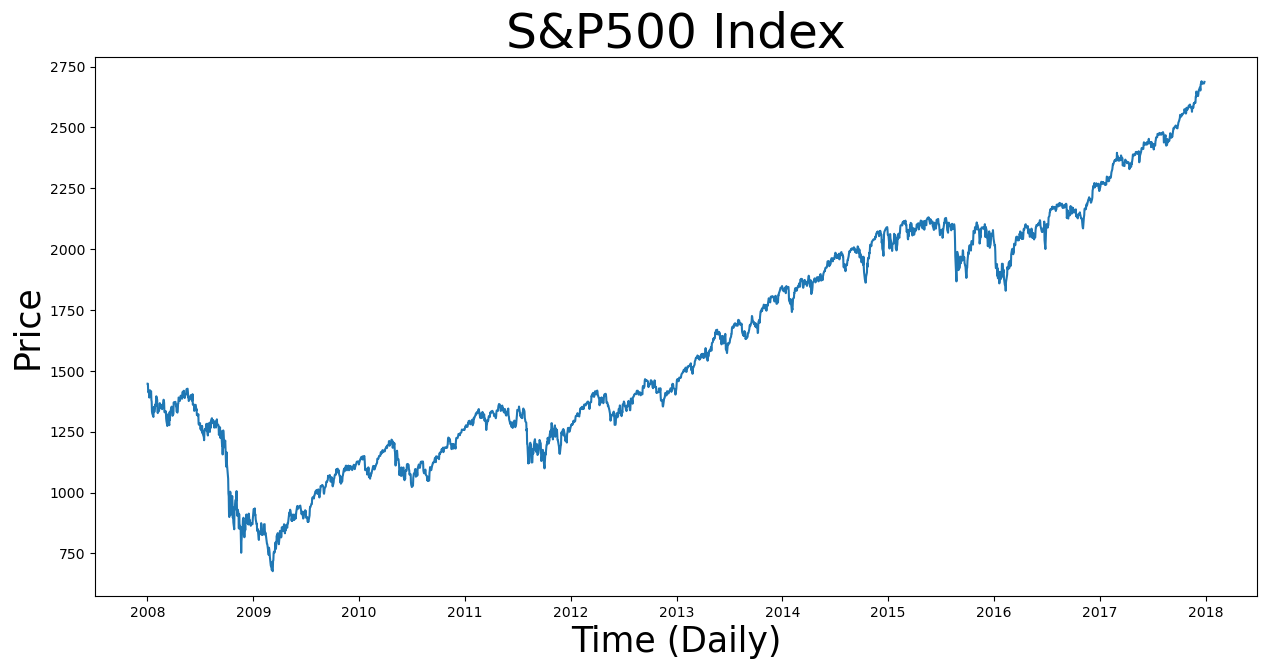

In [4]:
plt.figure(figsize=(15,7))
plt.plot(df)
plt.xlabel("Time (Daily)",fontsize=25)
plt.ylabel("Price",fontsize=25)
plt.title("S&P500 Index",fontsize=35)
plt.savefig(fname="S&P500.pdf", dpi=300)

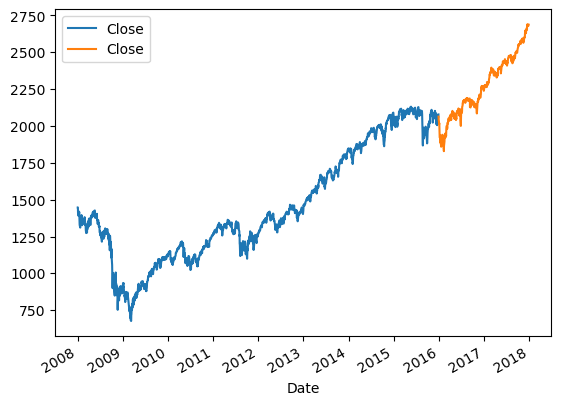

In [5]:
ax=train_data.plot()
test_data.plot(ax=ax)
plt.show()

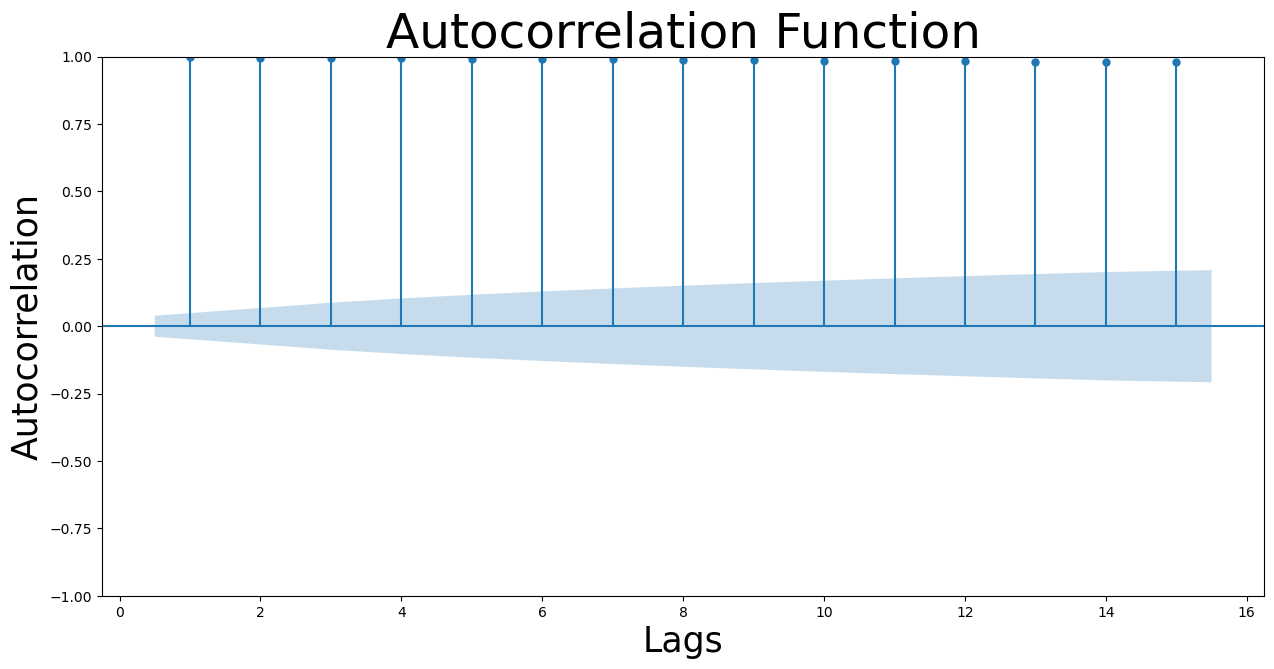

In [6]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(df, lags = 15, zero=False, ax=ax)
ax.set_xlabel('Lags', fontsize=25)
ax.set_ylabel('Autocorrelation', fontsize=25)
ax.set_title('Autocorrelation Function', fontsize=35)
plt.savefig(fname="S&P500_acf.pdf", dpi=300)

E:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


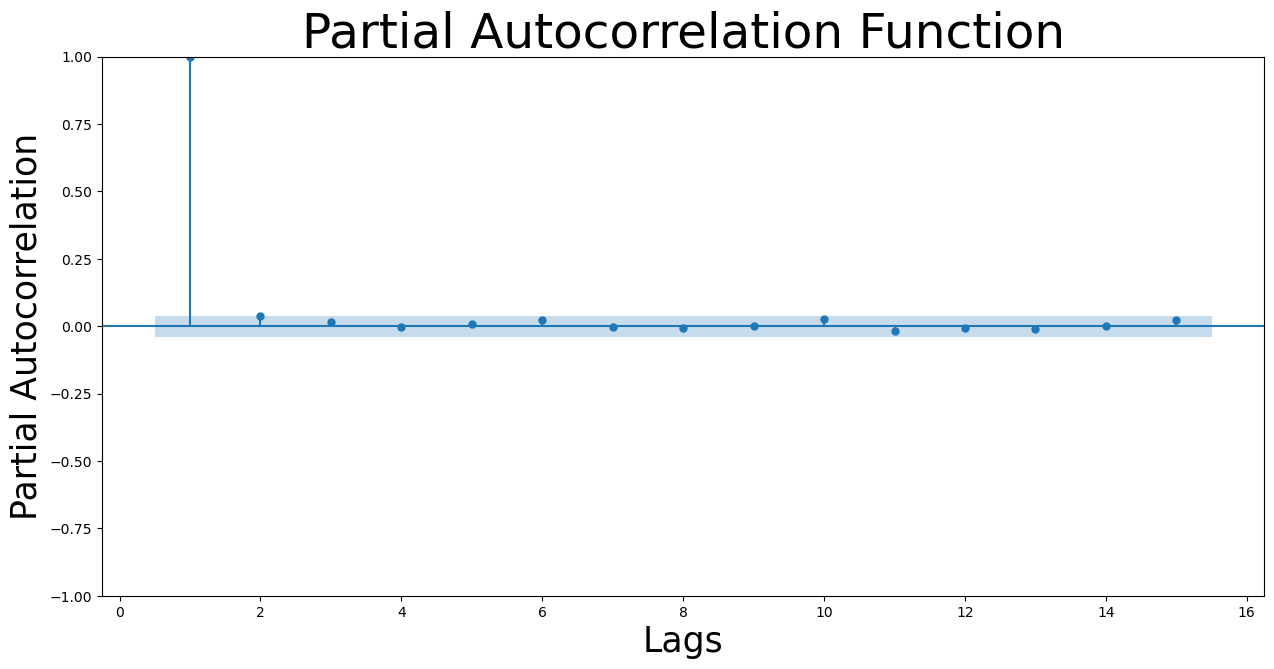

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(df, lags = 15, zero=False, ax=ax)
ax.set_xlabel('Lags', fontsize=25)
ax.set_ylabel('Partial Autocorrelation', fontsize=25)
ax.set_title('Partial Autocorrelation Function', fontsize=35)
plt.savefig(fname="S&P500_pacf.pdf", dpi=300)

In [8]:
model_auto = auto_arima(df.Close)
parameter = model_auto.get_params().get('order')
parameter

(5, 2, 0)

In [9]:
adf = adfuller(df)
print(adf[1], kpss(df)[1])

0.993660742302915 0.01


E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [10]:
adf = adfuller(df.diff().dropna())
print(adf[1], kpss(df.diff().dropna())[1])

7.681561133915992e-20 0.03839228677238932


In [11]:
adf = adfuller(df.diff().dropna().diff().dropna())
print(adf[1], kpss(df.diff().dropna().diff().dropna())[1])

5.6601825425278475e-30 0.1


E:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


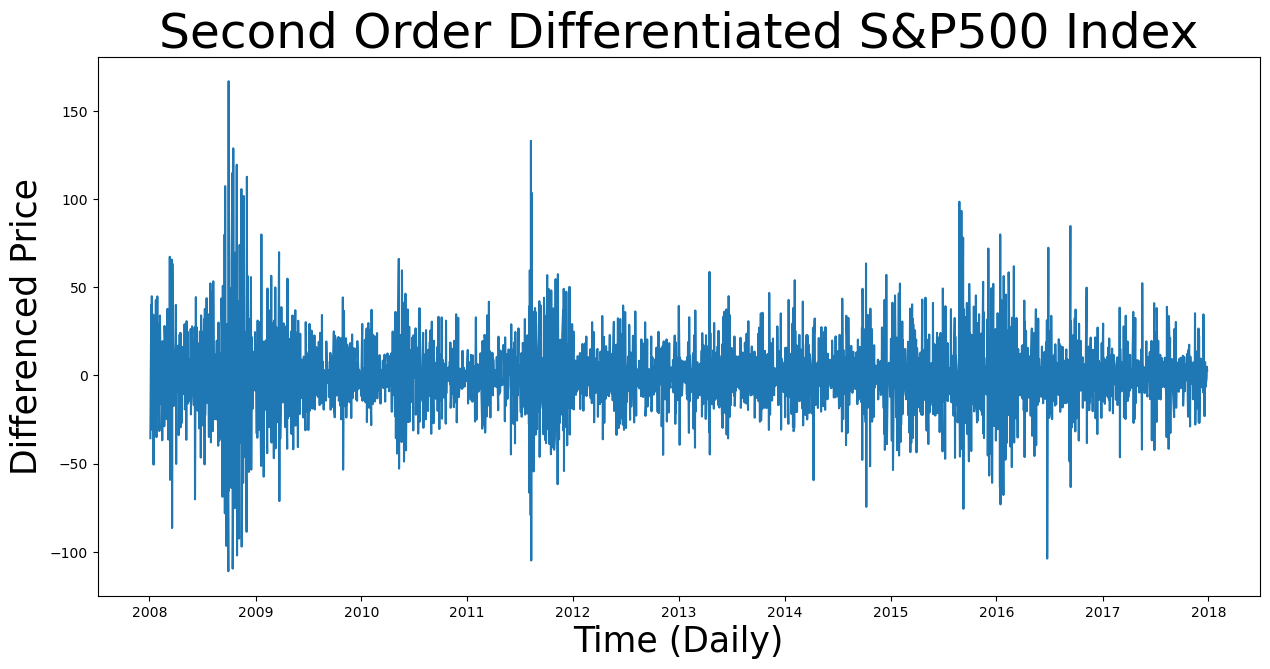

In [12]:
plt.figure(figsize=(15,7))
plt.plot(df.diff().dropna().diff().dropna())
plt.xlabel("Time (Daily)",fontsize=25)
plt.ylabel("Differenced Price",fontsize=25)
plt.title("Second Order Differentiated S&P500 Index",fontsize=35)
plt.savefig(fname="S&P500_diff.pdf", dpi=300)

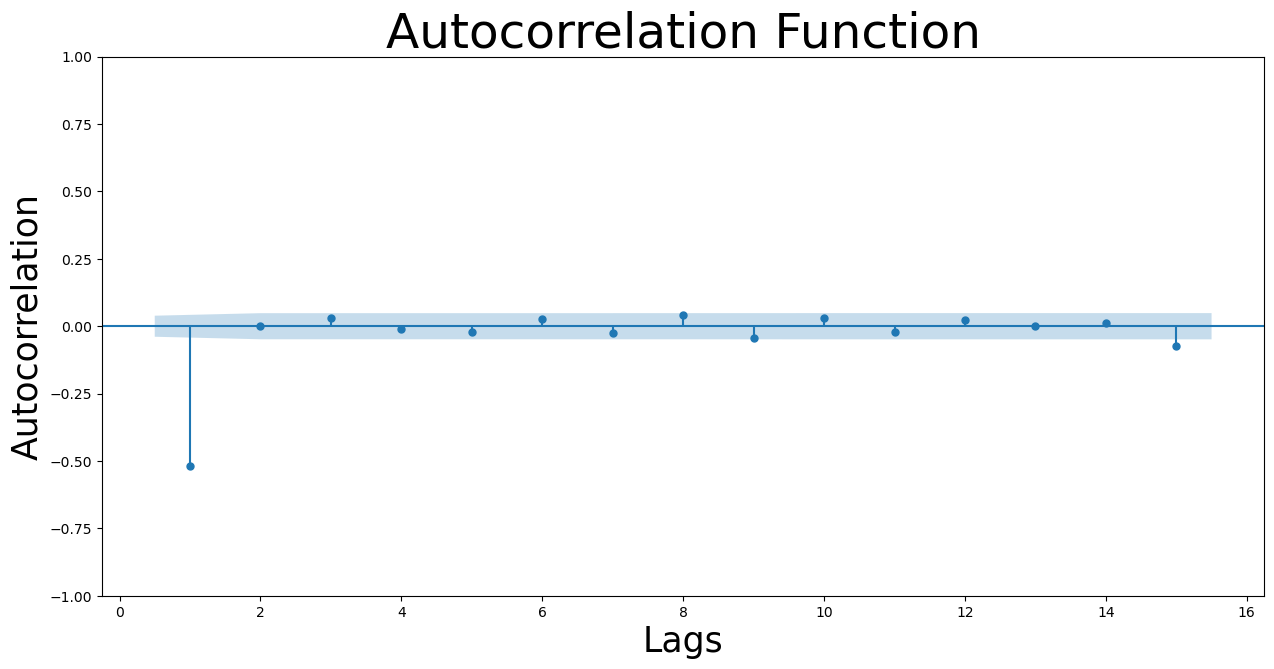

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(df.diff().dropna().diff().dropna(), lags = 15, zero=False, ax=ax)
ax.set_xlabel('Lags', fontsize=25)
ax.set_ylabel('Autocorrelation', fontsize=25)
ax.set_title('Autocorrelation Function', fontsize=35)
plt.savefig(fname="S&P500_diff_acf.pdf", dpi=300)

E:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


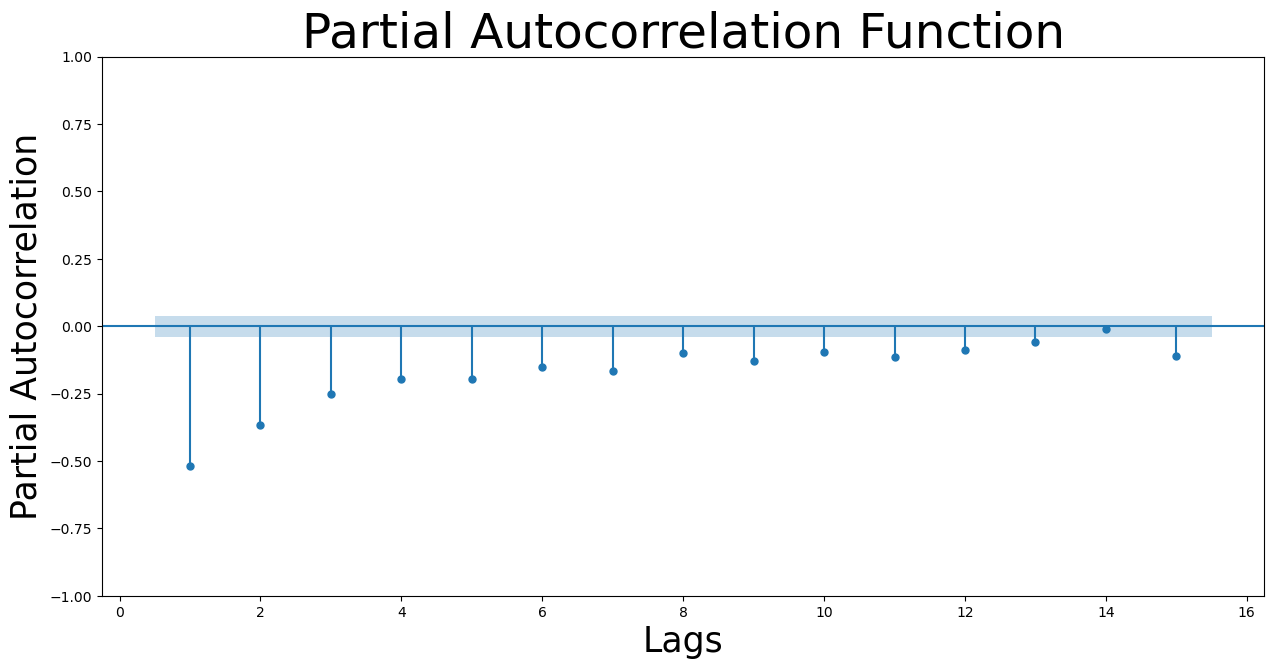

In [14]:
fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(df.diff().dropna().diff().dropna(), lags = 15, zero=False, ax=ax)
ax.set_xlabel('Lags', fontsize=25)
ax.set_ylabel('Partial Autocorrelation', fontsize=25)
ax.set_title('Partial Autocorrelation Function', fontsize=35)
plt.savefig(fname="S&P500_diff_pacf.pdf", dpi=300)

In [15]:
arima_model = ARIMA(train_data.Close, order = parameter)
results = arima_model.fit()
results.summary()

E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2013
Model:                 ARIMA(5, 2, 0)   Log Likelihood               -8693.544
Date:                Wed, 04 Oct 2023   AIC                          17399.089
Time:                        08:44:35   BIC                          17432.727
Sample:                             0   HQIC                         17411.437
                               - 2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8792      0.015    -60.435      0.000      -0.908      -0.851
ar.L2         -0.7282      0.020    -37.206      0.000      -0.767      -0.690
ar.L3         -0.5292      0.023    -23.215      0.000      -0.574      -0.484
ar.L4         -0.3582      0.021    -16.718      0.000      -0.400      -0.316
ar.L5         -0.1985      0.014    -14.063      0.000      -0.226      -0.171
sigma2       332.3029      5.716     58.138      0.000     321.100     343.506
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):              2348.98
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

E:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


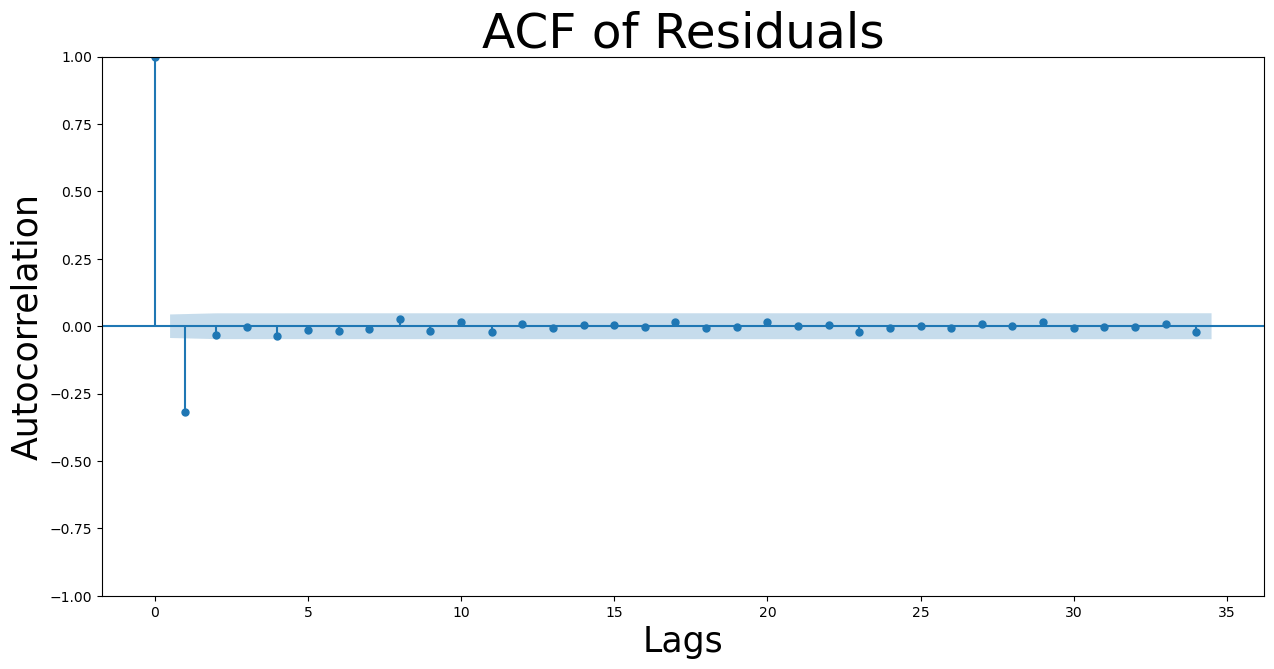

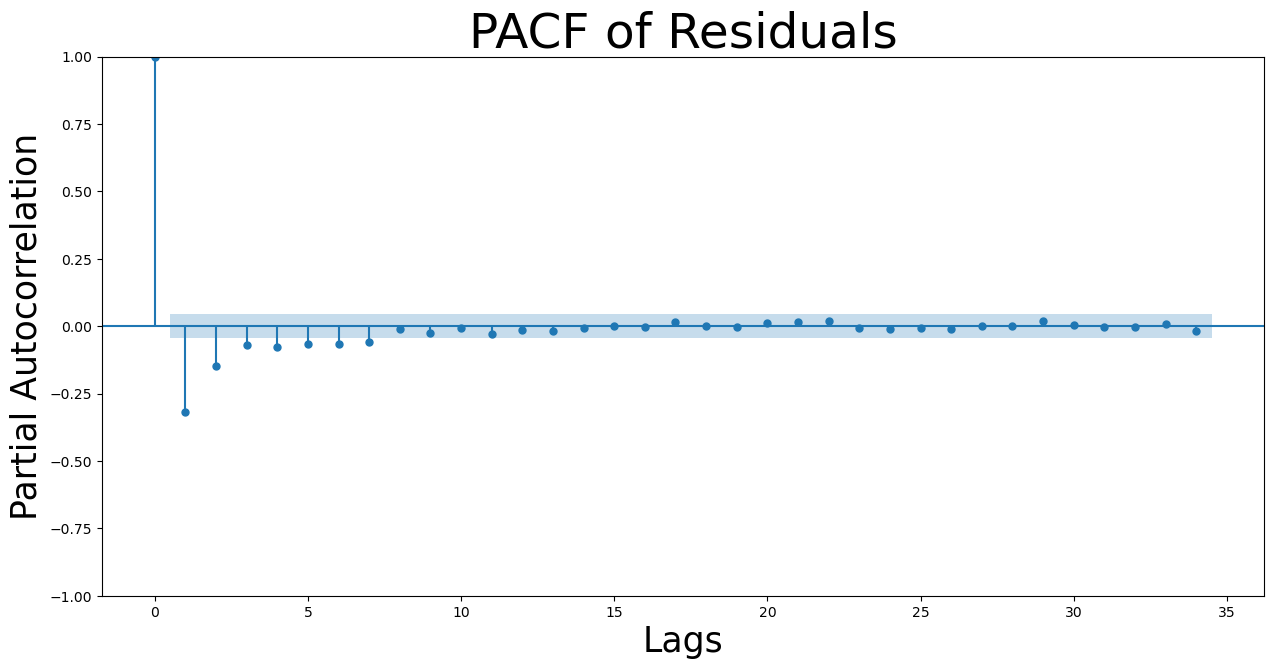

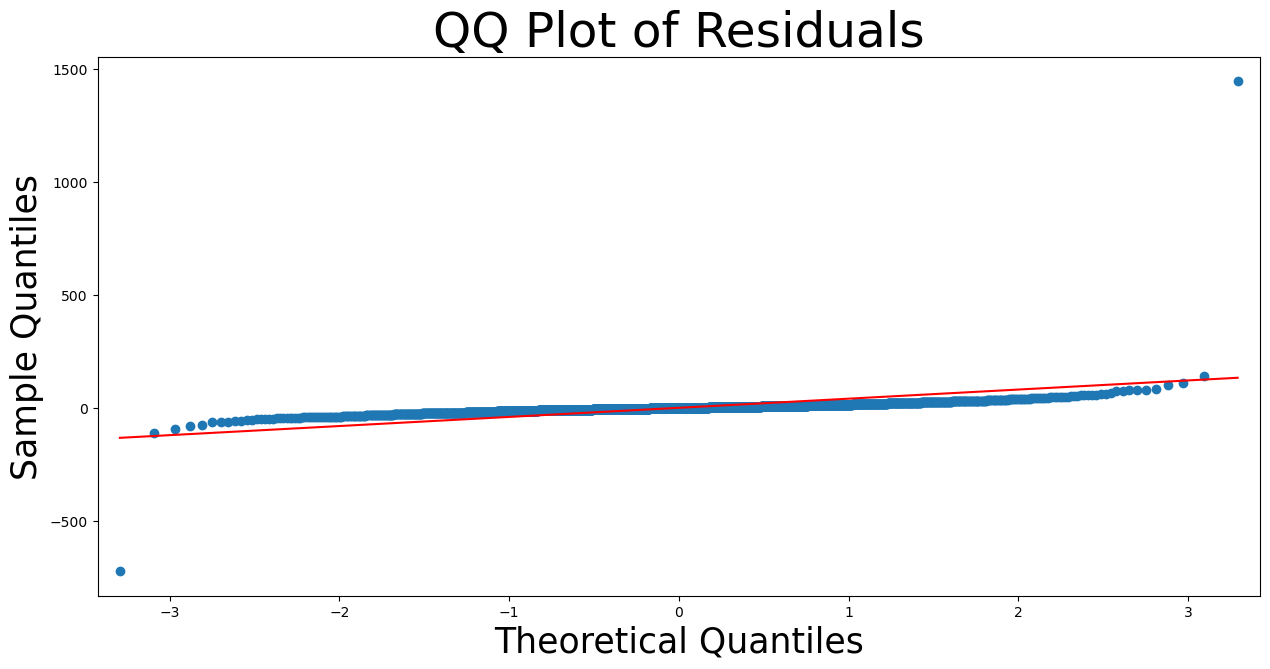

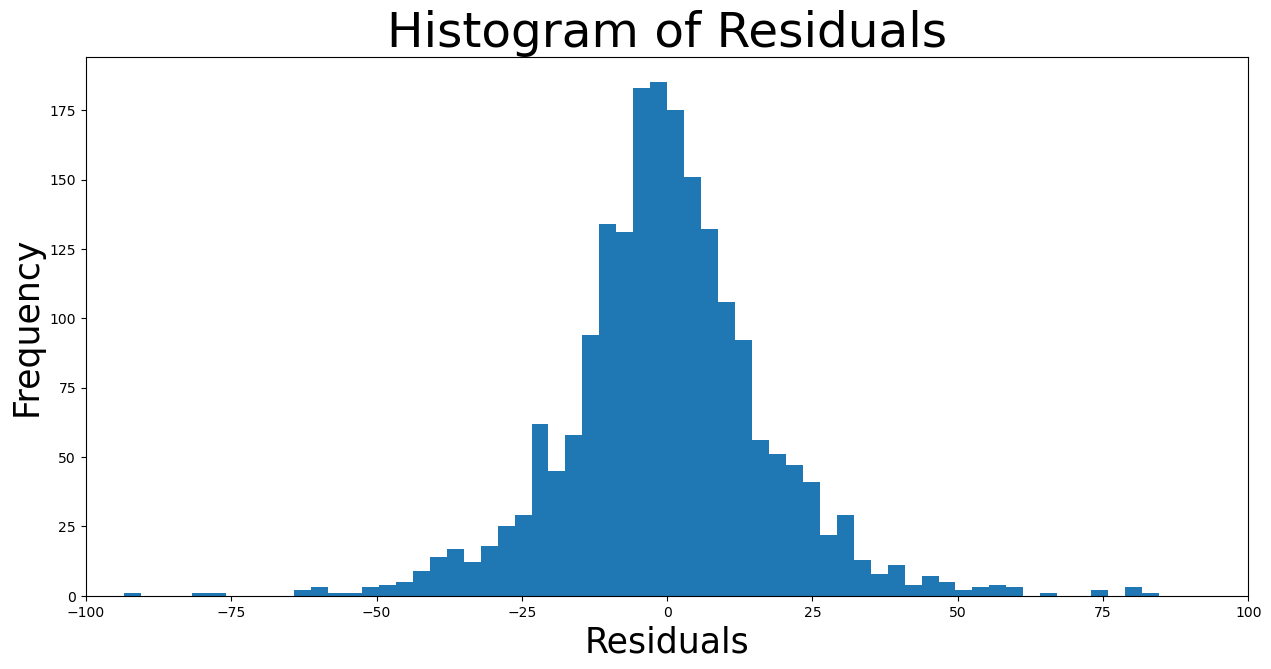

In [16]:
residuals = results.resid

# Plot ACF of the residuals
fig1, ax1 = plt.subplots(figsize=(15, 7))
sm.graphics.tsa.plot_acf(residuals, ax=ax1)
ax1.set_xlabel('Lags', fontsize=25)
ax1.set_ylabel('Autocorrelation', fontsize=25)
ax1.set_title('ACF of Residuals', fontsize=35)
plt.savefig(fname="S&P500_resid_acf.pdf", dpi=300)

# Plot PACF of the residuals
fig2, ax2 = plt.subplots(figsize=(15, 7))
sm.graphics.tsa.plot_pacf(residuals, ax=ax2)
ax2.set_xlabel('Lags', fontsize=25)
ax2.set_ylabel('Partial Autocorrelation', fontsize=25)
ax2.set_title('PACF of Residuals', fontsize=35)
plt.savefig(fname="S&P500_resid_pacf.pdf", dpi=300)

# Plot QQ plot of the residuals
fig3, ax3 = plt.subplots(figsize=(15, 7))
qqplot(residuals, line='s', ax=ax3)
ax3.set_xlabel('Theoretical Quantiles', fontsize=25)
ax3.set_ylabel('Sample Quantiles', fontsize=25)
ax3.set_title('QQ Plot of Residuals', fontsize=35)
plt.savefig(fname="S&P500_resid_qqplot.pdf", dpi=300)

# Plot histogram of the residuals
fig4, ax4 = plt.subplots(figsize=(15, 7))
ax4.hist(residuals, bins='auto')
ax4.set_xlabel('Residuals', fontsize=25)
ax4.set_ylabel('Frequency', fontsize=25)
ax4.set_title('Histogram of Residuals', fontsize=35)
plt.xlim([-100, 100])
plt.savefig(fname="S&P500_resid_hist.pdf", dpi=300)

In [17]:
arima_preds = []
dummy = list(train_data.Close)
dummy_test = list(test_data.Close)
for i in range(len(test_data)):
    dummy_model = ARIMA(dummy, order = parameter)
    yhat = list(dummy_model.fit().forecast())
    arima_preds.append(yhat)
    dummy.append(dummy_test[i])
    

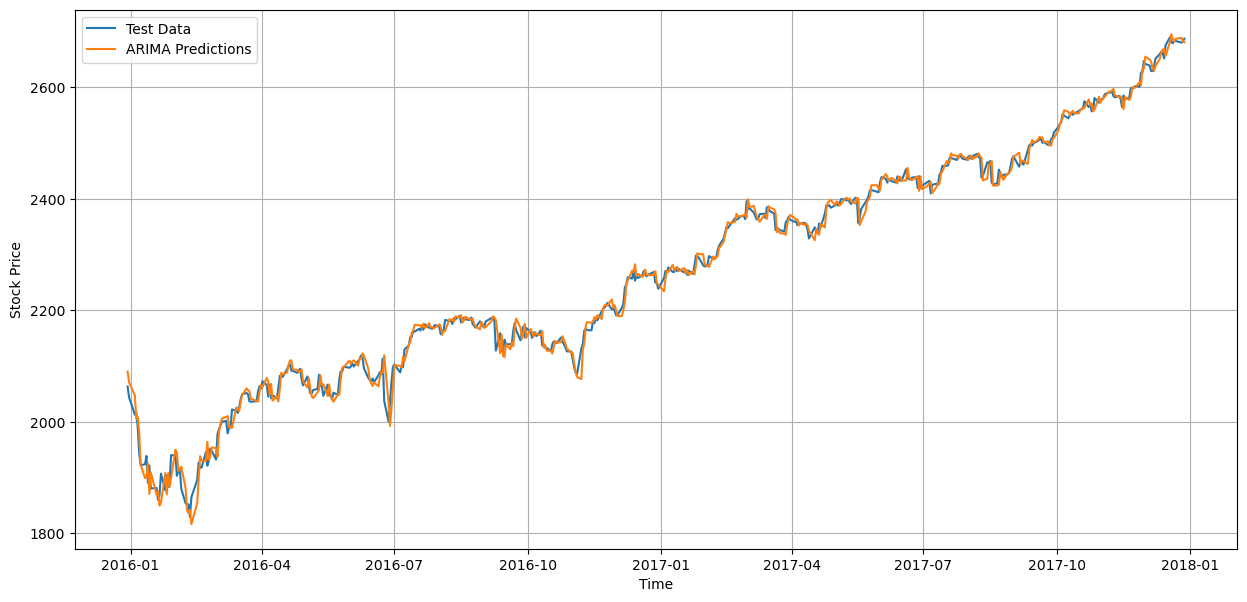

In [18]:
plt.figure(figsize=(15,7))
plt.plot(test_data,label='Test Data')
plt.grid(True)
plt.plot(test_data.index, arima_preds,label='ARIMA Predictions')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend(fontsize=10)
plt.show()

In [19]:
rmse_arima = rmse(test_data, arima_preds)
rmse_arima[0]

15.086704238896152

In [20]:
mape_arima = mape(test_data, arima_preds)
mape_arima*100

0.48562699083972843

In [21]:
mdae_arima = mdae(test_data, arima_preds)
print("Median Absolute Error:", mdae_arima)

Median Absolute Error: 7.08619025097164


In [22]:
arima_r2 = r2(test_data, arima_preds)
arima_r2

0.9946152269393714

In [23]:
val_size = int(len(train_data) * 0.2)
validation_data = train_data[-val_size:]
train_data = train_data[:-val_size]

In [24]:
arima_val_preds = []
dummy = list(train_data.Close)
dummy_test = list(validation_data.Close)
for i in range(len(validation_data)):
    dummy_model = ARIMA(dummy, order = parameter)
    yhat = list(dummy_model.fit().forecast())
    arima_val_preds.append(yhat)
    dummy.append(dummy_test[i])

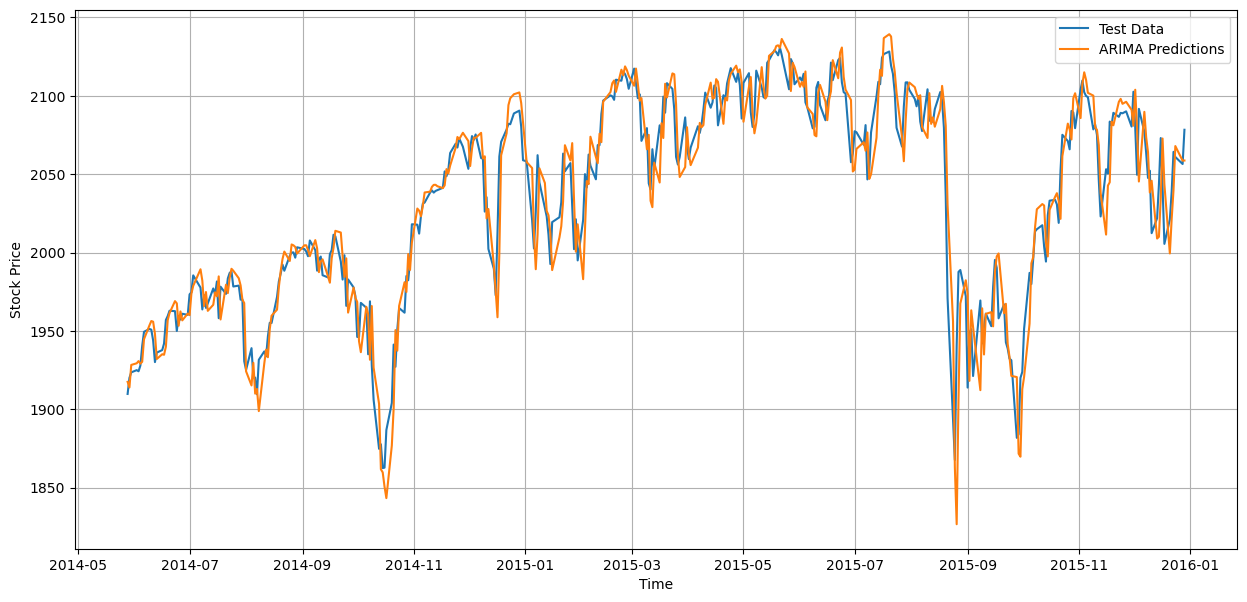

In [25]:
plt.figure(figsize=(15,7))
plt.plot(validation_data,label='Test Data')
plt.grid(True)
plt.plot(validation_data.index, arima_val_preds,label='ARIMA Predictions')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend(fontsize=10)
plt.show()

In [26]:
train_data

,Close
Date,
2008-01-02,1447.16
2008-01-03,1447.16
2008-01-04,1411.63
2008-01-07,1416.18
2008-01-08,1390.19
...,...
2014-05-20,1872.83
2014-05-21,1888.03
2014-05-22,1892.49


In [27]:
validation_data

,Close
Date,
2014-05-28,1909.78
2014-05-29,1920.03
2014-05-30,1923.57
2014-06-02,1924.97
2014-06-03,1924.24
...,...
2015-12-22,2038.97
2015-12-23,2064.29
2015-12-24,2060.99


In [28]:
test_data

,Close
Date,
2015-12-30,2063.36
2015-12-31,2043.94
2016-01-04,2012.66
2016-01-05,2016.71
2016-01-06,1990.26
...,...
2017-12-21,2684.57
2017-12-22,2683.34
2017-12-26,2680.50


In [29]:
WINDOW_SIZE = 7

In [30]:
ext_test_data = test_data
ext_test_data = pd.concat([validation_data[-WINDOW_SIZE:], test_data])
ext_val_data = validation_data
ext_val_data = pd.concat([train_data[-WINDOW_SIZE:], validation_data])

In [31]:
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_validation_data = scaler.transform(ext_val_data)
scaled_test_data = scaler.transform(ext_test_data)

In [32]:
norm_arima_preds = scaler.transform(arima_preds)
norm_arima_preds

E:\Anaconda\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[1.14410653],
       [1.12876324],
       [1.10968384],
       [1.07556566],
       [1.0782679 ],
       [1.05512117],
       [1.00875393],
       [0.98951437],
       [0.99132885],
       [1.01060178],
       [0.96654936],
       [0.99776375],
       [0.96560368],
       [0.97052832],
       [0.94948004],
       [0.95395226],
       [0.99691298],
       [0.96594941],
       [0.99675846],
       [0.97652804],
       [0.98982813],
       [1.03072861],
       [1.02601338],
       [0.99972475],
       [1.00151381],
       [1.00619226],
       [0.97478302],
       [0.94265105],
       [0.93856586],
       [0.94358089],
       [0.92251154],
       [0.95323706],
       [0.9862001 ],
       [1.02138057],
       [1.01505271],
       [1.01439828],
       [1.04222838],
       [1.01606588],
       [1.02029098],
       [1.03399115],
       [1.03318744],
       [1.02033618],
       [1.05620532],
       [1.06775934],
       [1.07588394],
       [1.07825527],
       [1.0795875 ],
       [1.062

In [33]:
norm_arima_rmse = rmse(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(norm_arima_preds).squeeze())
norm_arima_mape = mape(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(norm_arima_preds).squeeze())
norm_arima_mdae = mdae(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(norm_arima_preds).squeeze())
print(norm_arima_rmse, norm_arima_mape, norm_arima_mdae)

0.012212197250154731 0.007081847981251651 0.005736040935559461


In [34]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data[i:i+sequence_length]
        sequences.append(sequence)
    return sequences

In [35]:
train_sequences = create_sequences(scaled_train_data, WINDOW_SIZE+1)
train_sequences = np.array(train_sequences)
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1]
print(X_train.shape, y_train.shape)

(1604, 7, 1) (1604, 1)


In [36]:
test_sequences = create_sequences(scaled_test_data, WINDOW_SIZE+1)
test_sequences = np.array(test_sequences)
X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]
print(X_test.shape, y_test.shape)

(504, 7, 1) (504, 1)


In [37]:
val_sequences = create_sequences(scaled_validation_data, WINDOW_SIZE+1)
val_sequences = np.array(val_sequences)
X_val = val_sequences[:, :-1]
y_val = val_sequences[:, -1]
print(X_val.shape, y_val.shape)

(402, 7, 1) (402, 1)


In [38]:
optimizer = 'adam'
batch_size = 32

In [ ]:
# def lstm_model(hp):
#     model = Sequential()
#     model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=256,step=16),return_sequences=True, input_shape=(7,1)))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=16),return_sequences=True))
#     model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=256,step=16)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(hp.Int('input_unit',min_value=32,max_value=256,step=16)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model

In [ ]:
# lstm_tuner= kt.RandomSearch(
#     lstm_model,
#     objective='val_loss',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='mydir',
#     project_name='Stock',
# )

In [ ]:
# lstm_tuner.search(
#     X_train,
#     y_train,
#     epochs=20,
#     batch_size=128,
#     validation_data=(X_val,y_val),
# )

In [452]:
# best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]
# best_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 208)            174720    
                                                                 
 lstm_1 (LSTM)               (None, 7, 128)            172544    
                                                                 
 lstm_2 (LSTM)               (None, 208)               280384    
                                                                 
 dropout (Dropout)           (None, 208)               0         
                                                                 
 dense (Dense)               (None, 208)               43472     
                                                                 
 dropout_1 (Dropout)         (None, 208)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [39]:
lstm_model = Sequential()
lstm_model.add(LSTM(208,return_sequences=True, input_shape=(7,1)))
lstm_model.add(LSTM(128,return_sequences=True))
lstm_model.add(LSTM(208))
lstm_model.add(Dropout(0))
lstm_model.add(Dense(208))
lstm_model.add(Dropout(0))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [40]:
history_lstm = lstm_model.fit(X_train, y_train, epochs=100, batch_size = batch_size, validation_data=(X_val, y_val))

Epoch 1/100
51/51 [==============================] - 11s 29ms/step - loss: 0.0220 - val_loss: 0.0013
Epoch 2/100
51/51 [==============================] - 1s 10ms/step - loss: 6.3385e-04 - val_loss: 8.3220e-04
Epoch 3/100
51/51 [==============================] - 1s 11ms/step - loss: 5.9900e-04 - val_loss: 0.0024
Epoch 4/100
51/51 [==============================] - 1s 10ms/step - loss: 5.9704e-04 - val_loss: 7.9710e-04
Epoch 5/100
51/51 [==============================] - 1s 11ms/step - loss: 5.7874e-04 - val_loss: 7.9666e-04
Epoch 6/100
51/51 [==============================] - 1s 13ms/step - loss: 5.7536e-04 - val_loss: 9.7372e-04
Epoch 7/100
51/51 [==============================] - 1s 12ms/step - loss: 7.1541e-04 - val_loss: 9.0775e-04
Epoch 8/100
51/51 [==============================] - 1s 11ms/step - loss: 5.9104e-04 - val_loss: 7.3729e-04
Epoch 9/100
51/51 [==============================] - 0s 10ms/step - loss: 5.9088e-04 - val_loss: 7.4987e-04
Epoch 10/100
51/51 [===================

Epoch 77/100
51/51 [==============================] - 1s 11ms/step - loss: 2.0558e-04 - val_loss: 0.0011
Epoch 78/100
51/51 [==============================] - 1s 11ms/step - loss: 2.4380e-04 - val_loss: 2.1982e-04
Epoch 79/100
51/51 [==============================] - 1s 10ms/step - loss: 2.1951e-04 - val_loss: 2.7392e-04
Epoch 80/100
51/51 [==============================] - 1s 10ms/step - loss: 2.4897e-04 - val_loss: 3.8087e-04
Epoch 81/100
51/51 [==============================] - 1s 12ms/step - loss: 2.3937e-04 - val_loss: 2.2682e-04
Epoch 82/100
51/51 [==============================] - 1s 10ms/step - loss: 2.3691e-04 - val_loss: 7.4604e-04
Epoch 83/100
51/51 [==============================] - 1s 10ms/step - loss: 2.2801e-04 - val_loss: 8.2248e-04
Epoch 84/100
51/51 [==============================] - 1s 11ms/step - loss: 2.3389e-04 - val_loss: 6.2858e-04
Epoch 85/100
51/51 [==============================] - 1s 10ms/step - loss: 2.1142e-04 - val_loss: 2.0479e-04
Epoch 86/100
51/51 [===

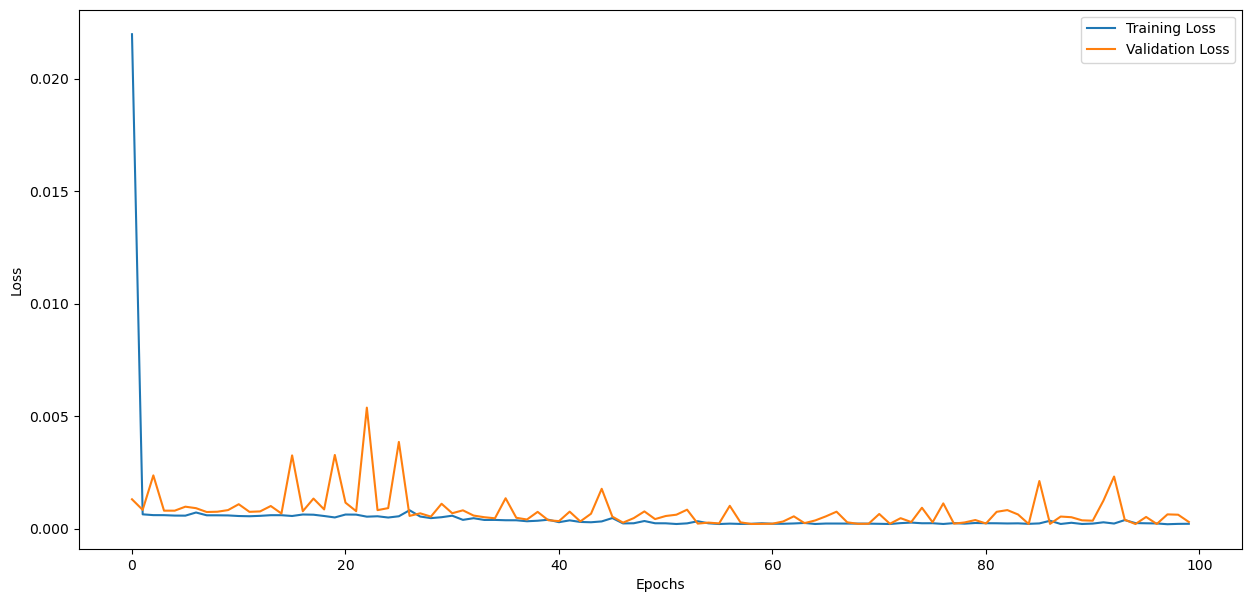

In [49]:
history_df = pd.DataFrame(history_lstm.history)

# Plot the data with labels and increased figsize
plt.figure(figsize=(15, 7))  # Set the figsize
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(fname="S&P500_lstm_lve.pdf", dpi=300)

In [50]:
lstm_norm_val_preds = lstm_model.predict(X_val)
lstm_val_preds = scaler.inverse_transform(lstm_norm_val_preds)

13/13 [==============================] - 1s 7ms/step


In [51]:
from sklearn.linear_model import LinearRegression
regX = np.concatenate((np.array(arima_val_preds),lstm_val_preds),axis=1)
regY = validation_data.Close.values.reshape(-1,1)
reg = LinearRegression().fit(regX, regY)
print(reg.coef_, reg.intercept_, reg.score(regX, regY))

[[0.10063994 0.8464853 ]] [97.70293498] 0.9273928389689756


In [52]:
lstm_norm_preds = lstm_model.predict(X_test)
lstm_preds = scaler.inverse_transform(lstm_norm_preds)

16/16 [==============================] - 0s 8ms/step


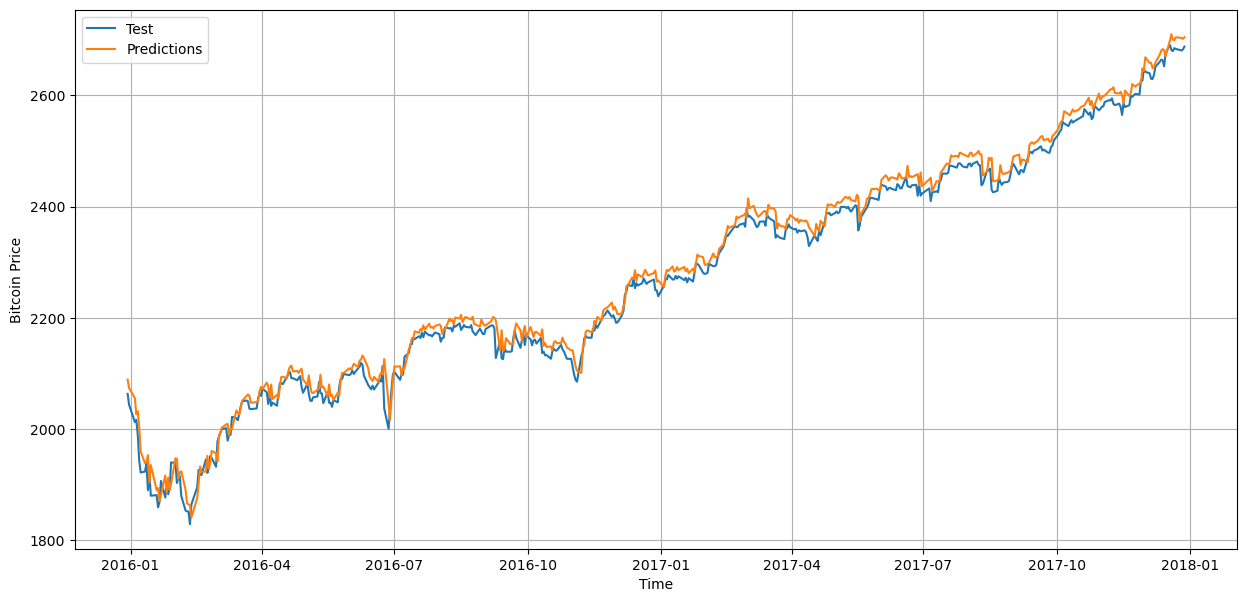

In [53]:
plt.figure(figsize=(15,7))
plt.plot(test_data,label='Test')
plt.grid(True)
plt.plot(test_data.index, lstm_preds,label='Predictions')
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=10)
plt.show()

In [54]:
norm_reg_test = np.concatenate((np.array(norm_arima_preds),lstm_norm_preds),axis=1)
arima_lstm_norm_preds = reg.predict(norm_reg_test)

In [55]:
reg_test = np.concatenate((np.array(arima_preds),lstm_preds),axis=1)
arima_lstm_preds = reg.predict(reg_test)

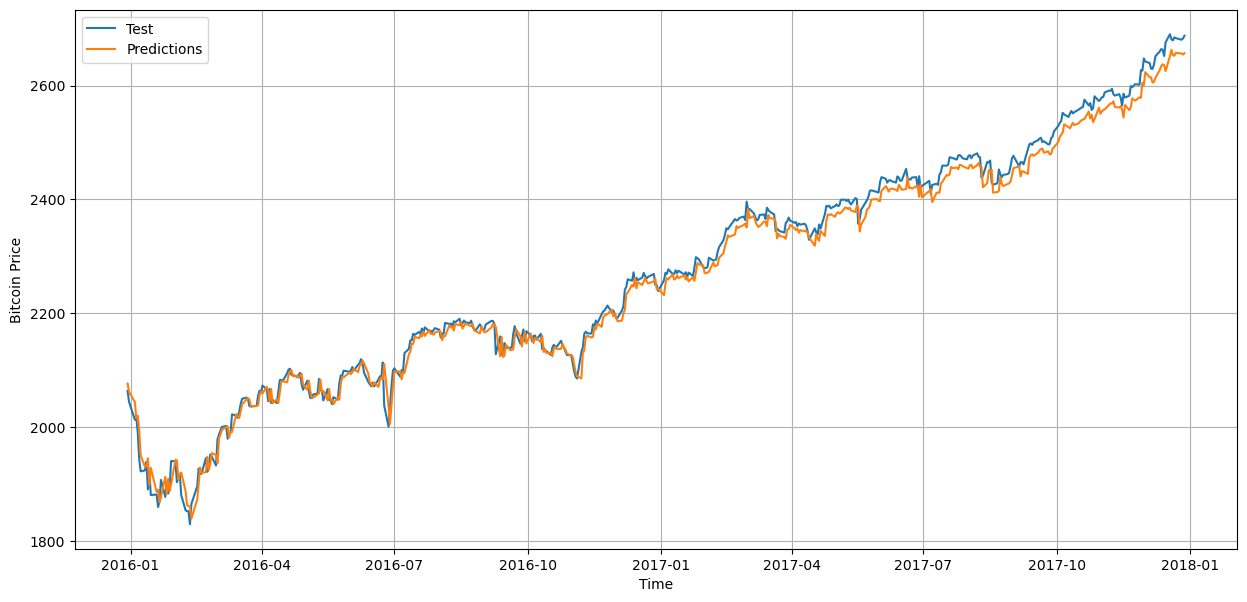

In [56]:
plt.figure(figsize=(15,7))
plt.plot(test_data,label='Test')
plt.grid(True)
plt.plot(test_data.index, arima_lstm_preds,label='Predictions')
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=10)
plt.show()

In [57]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store evaluation results
norm_lstm_rmse_scores = []
norm_lstm_mdae_scores = []
norm_lstm_mape_scores = []

lstm_rmse_scores = []
lstm_mdae_scores = []
lstm_mape_scores = []
lstm_r2_scores = []

# Create the cross-validation object
kfold = KFold(n_splits=num_folds)
lstm_scaler = MinMaxScaler()
X = df.Close

i = 0

# Iterate over each fold
for train_index, test_index in kfold.split(X.values):
    
    i+=1
    if i==1: continue
    
    # Split the data into training and test sets
    k_train_data, k_test_data = X[train_index], X[test_index]
    scaled_k_train_data = lstm_scaler.fit_transform(k_train_data.values.reshape(-1,1))
    scaled_k_test_data = lstm_scaler.transform(k_test_data.values.reshape(-1,1))
    
    train_sequences = create_sequences(scaled_k_train_data, WINDOW_SIZE+1)
    train_sequences = np.array(train_sequences)
    k_X_train = train_sequences[:, :-1]
    k_y_train = train_sequences[:, -1]
    
    test_sequences = create_sequences(scaled_k_test_data, WINDOW_SIZE+1)
    test_sequences = np.array(test_sequences)
    k_X_test = test_sequences[:, :-1]
    k_y_test = test_sequences[:, -1]
    
    k_norm_lstm_preds = lstm_model.predict(k_X_test)
    
    norm_lstm_rmse_scores.append(rmse(k_norm_lstm_preds, k_y_test)[0])
    norm_lstm_mdae_scores.append(mdae(k_norm_lstm_preds, k_y_test))
    norm_lstm_mape_scores.append(mape(k_norm_lstm_preds, k_y_test))
    
    k_lstm_preds = lstm_scaler.inverse_transform(k_norm_lstm_preds)
    
    lstm_rmse_scores.append(rmse(k_lstm_preds, k_y_test)[0])
    lstm_mdae_scores.append(mdae(k_lstm_preds, k_y_test))
    lstm_mape_scores.append(mape(k_lstm_preds, k_y_test))
    lstm_r2_scores.append(r2(k_lstm_preds, k_y_test))


8/8 [==============================] - 0s 7ms/step


In [58]:
# Calculate the average and standard deviation of the evaluation metrics across all folds
norm_avg_lstm_rmse = np.mean(norm_lstm_rmse_scores)
norm_std_lstm_rmse = np.std(norm_lstm_rmse_scores)
norm_avg_lstm_mdae = np.mean(norm_lstm_mdae_scores)
norm_std_lstm_mdae = np.std(norm_lstm_mdae_scores)
norm_avg_lstm_mape = np.mean(norm_lstm_mape_scores)
norm_std_lstm_mape = np.std(norm_lstm_mape_scores)

# Print the overall evaluation results
print(f"Average RMSE: {norm_avg_lstm_rmse:.4f} +/- {norm_std_lstm_rmse:.4f}")
print(f"Average MDAE: {norm_avg_lstm_mdae:.4f} +/- {norm_std_lstm_mdae:.4f}")
print(f"Average MAPE: {norm_avg_lstm_mape:.4f} +/- {norm_std_lstm_mape:.4f}")

Average RMSE: 0.0091 +/- 0.0017
Average MDAE: 0.0065 +/- 0.0019
Average MAPE: 3.0386 +/- 8.5463


In [59]:
# Calculate the average and standard deviation of the evaluation metrics across all folds
avg_lstm_rmse = np.mean(lstm_rmse_scores)
std_lstm_rmse = np.std(lstm_rmse_scores)
avg_lstm_mdae = np.mean(lstm_mdae_scores)
std_lstm_mdae = np.std(lstm_mdae_scores)
avg_lstm_mape = np.mean(lstm_mape_scores)
std_lstm_mape = np.std(lstm_mape_scores)
avg_lstm_r2 = np.mean(lstm_r2_scores)
std_lstm_r2 = np.std(lstm_r2_scores)

# Print the overall evaluation results
print(f"Average RMSE: {avg_lstm_rmse:.4f} +/- {std_lstm_rmse:.4f}")
print(f"Average MDAE: {avg_lstm_mdae:.4f} +/- {std_lstm_mdae:.4f}")
print(f"Average MAPE: {avg_lstm_mape:.4f} +/- {std_lstm_mape:.4f}")
print(f"Average R2: {avg_lstm_r2:.4f} +/- {std_lstm_r2:.4f}")

Average RMSE: 1656.4853 +/- 487.4172
Average MDAE: 1658.1351 +/- 489.2004
Average MAPE: 0.9997 +/- 0.0001
Average R2: -552.6078 +/- 363.1162


In [60]:
# def bi_lstm_model(hp):
#     model = Sequential()
#     model.add(Bidirectional(LSTM(hp.Int('input_unit',min_value=32,max_value=256,step=16),return_sequences=True, input_shape=(7,1))))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Bidirectional(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=16),return_sequences=True)))
#     model.add(Bidirectional(LSTM(hp.Int('input_unit',min_value=32,max_value=256,step=16))))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(hp.Int('input_unit',min_value=32,max_value=256,step=16)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer=optimizer)
#     return model

In [61]:
# bi_lstm_tuner= kt.RandomSearch(
#     bi_lstm_model,
#     objective='val_loss',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='mydir',
#     project_name='Stock_bi_lstm',
# )

In [62]:
# bi_lstm_tuner.search(
#     X_train,
#     y_train,
#     epochs=20,
#     batch_size=128,
#     validation_data=(X_val,y_val),
# )

In [63]:
# best_bi_lstm_model = bi_lstm_tuner.get_best_models(num_models=1)[0]
# best_bi_lstm_model.build(input_shape=(None,WINDOW_SIZE,1))
# best_bi_lstm_model.summary()

In [64]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(224,return_sequences=True, input_shape=(7,1))))
bi_lstm_model.add(Bidirectional(LSTM(64,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(96,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(160,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(128,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(160,return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(224)))
bi_lstm_model.add(Dropout(0))
bi_lstm_model.add(Dense(112))
bi_lstm_model.add(Dropout(0))
bi_lstm_model.add(Dense(1))
bi_lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [65]:
history_bi_lstm = bi_lstm_model.fit(X_train, y_train, epochs=100, batch_size = batch_size, validation_data=(X_val, y_val))

Epoch 1/100
51/51 [==============================] - 28s 124ms/step - loss: 0.0274 - val_loss: 5.2501e-04
Epoch 2/100
51/51 [==============================] - 2s 35ms/step - loss: 5.4408e-04 - val_loss: 0.0027
Epoch 3/100
51/51 [==============================] - 2s 34ms/step - loss: 7.4542e-04 - val_loss: 7.4542e-04
Epoch 4/100
51/51 [==============================] - 2s 34ms/step - loss: 4.5360e-04 - val_loss: 0.0016
Epoch 5/100
51/51 [==============================] - 2s 35ms/step - loss: 5.5386e-04 - val_loss: 0.0099
Epoch 6/100
51/51 [==============================] - 2s 47ms/step - loss: 8.2962e-04 - val_loss: 0.0016
Epoch 7/100
51/51 [==============================] - 3s 53ms/step - loss: 6.2245e-04 - val_loss: 0.0034
Epoch 8/100
51/51 [==============================] - 3s 52ms/step - loss: 5.3903e-04 - val_loss: 0.0026
Epoch 9/100
51/51 [==============================] - 2s 46ms/step - loss: 4.2675e-04 - val_loss: 9.5742e-04
Epoch 10/100
51/51 [==============================] - 

Epoch 78/100
51/51 [==============================] - 2s 39ms/step - loss: 2.9828e-04 - val_loss: 0.0055
Epoch 79/100
51/51 [==============================] - 2s 41ms/step - loss: 4.0216e-04 - val_loss: 9.1096e-04
Epoch 80/100
51/51 [==============================] - 2s 34ms/step - loss: 3.6477e-04 - val_loss: 7.3106e-04
Epoch 81/100
51/51 [==============================] - 2s 36ms/step - loss: 3.4946e-04 - val_loss: 0.0020
Epoch 82/100
51/51 [==============================] - 2s 36ms/step - loss: 2.9112e-04 - val_loss: 0.0022
Epoch 83/100
51/51 [==============================] - 2s 43ms/step - loss: 3.7052e-04 - val_loss: 0.0023
Epoch 84/100
51/51 [==============================] - 3s 52ms/step - loss: 3.2236e-04 - val_loss: 0.0041
Epoch 85/100
51/51 [==============================] - 2s 39ms/step - loss: 5.5228e-04 - val_loss: 0.0046
Epoch 86/100
51/51 [==============================] - 2s 40ms/step - loss: 6.6377e-04 - val_loss: 0.0078
Epoch 87/100
51/51 [===========================

<Axes: >

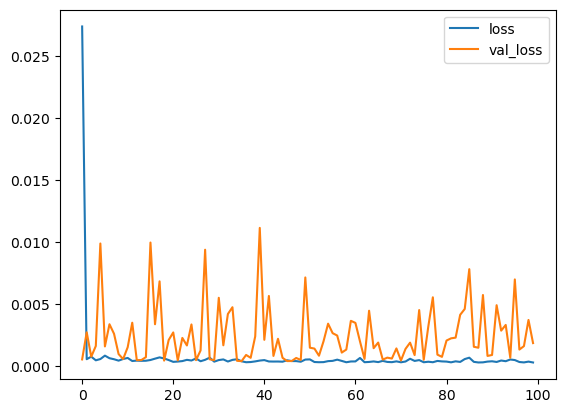

In [66]:
pd.DataFrame(history_bi_lstm.history).plot()

In [67]:
bi_lstm_norm_preds = bi_lstm_model.predict(X_test)
bi_lstm_preds = scaler.inverse_transform(bi_lstm_norm_preds)

16/16 [==============================] - 5s 25ms/step


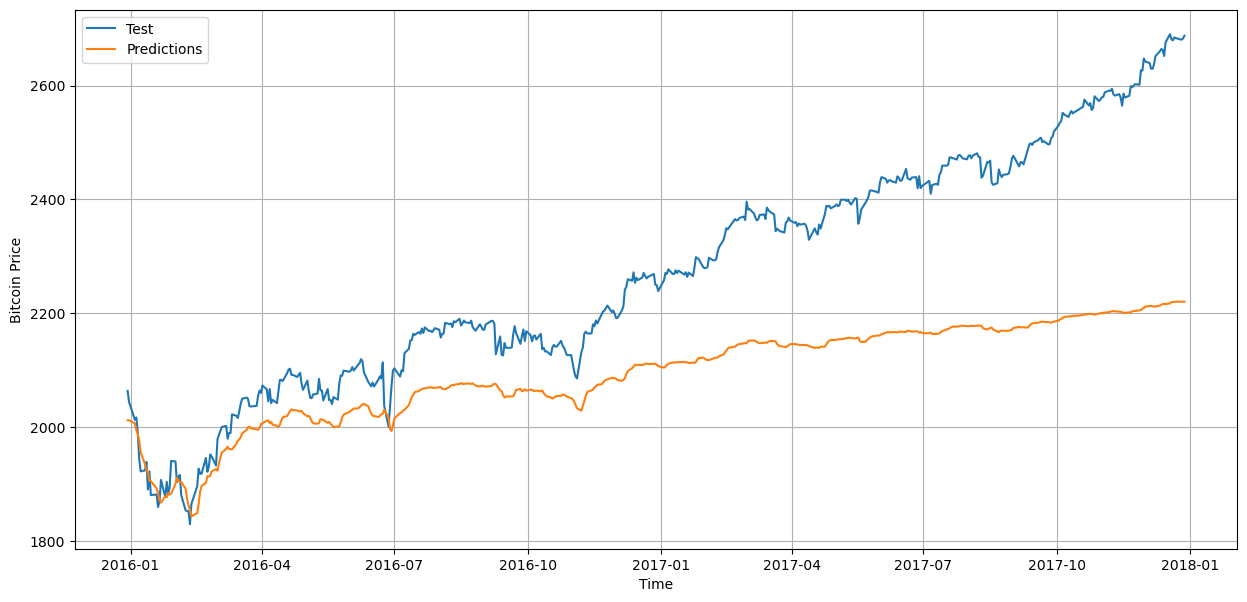

In [68]:
plt.figure(figsize=(15,7))
plt.plot(test_data,label='Test')
plt.grid(True)
plt.plot(test_data.index, bi_lstm_preds,label='Predictions')
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=10)
plt.show()

In [69]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store evaluation results
norm_bi_lstm_rmse_scores = []
norm_bi_lstm_mdae_scores = []
norm_bi_lstm_mape_scores = []

bi_lstm_rmse_scores = []
bi_lstm_mdae_scores = []
bi_lstm_mape_scores = []

# Create the cross-validation object
kfold = KFold(n_splits=num_folds)
bi_lstm_scaler = MinMaxScaler()
X = df.Close

i = 0

# Iterate over each fold
for train_index, test_index in kfold.split(X.values):
    
    i+=1
    if i==1: continue
    
    # Split the data into training and test sets
    k_train_data, k_test_data = X[train_index], X[test_index]
    scaled_k_train_data = bi_lstm_scaler.fit_transform(k_train_data.values.reshape(-1,1))
    scaled_k_test_data = bi_lstm_scaler.transform(k_test_data.values.reshape(-1,1))
    
    train_sequences = create_sequences(scaled_k_train_data, WINDOW_SIZE+1)
    train_sequences = np.array(train_sequences)
    k_X_train = train_sequences[:, :-1]
    k_y_train = train_sequences[:, -1]
    
    test_sequences = create_sequences(scaled_k_test_data, WINDOW_SIZE+1)
    test_sequences = np.array(test_sequences)
    k_X_test = test_sequences[:, :-1]
    k_y_test = test_sequences[:, -1]
    
    k_norm_bi_lstm_preds = bi_lstm_model.predict(k_X_test)
    
    norm_bi_lstm_rmse_scores.append(rmse(k_norm_bi_lstm_preds, k_y_test)[0])
    norm_bi_lstm_mdae_scores.append(mdae(k_norm_bi_lstm_preds, k_y_test))
    norm_bi_lstm_mape_scores.append(mape(k_norm_bi_lstm_preds, k_y_test))
    
    k_bi_lstm_preds = bi_lstm_scaler.inverse_transform(k_norm_bi_lstm_preds)
    
    bi_lstm_rmse_scores.append(rmse(k_bi_lstm_preds, k_y_test)[0])
    bi_lstm_mdae_scores.append(mdae(k_bi_lstm_preds, k_y_test))
    bi_lstm_mape_scores.append(mape(k_bi_lstm_preds, k_y_test))


8/8 [==============================] - 0s 12ms/step


In [70]:
# Calculate the average and standard deviation of the evaluation metrics across all folds
norm_avg_bi_lstm_rmse = np.mean(norm_bi_lstm_rmse_scores)
norm_std_bi_lstm_rmse = np.std(norm_bi_lstm_rmse_scores)
norm_avg_bi_lstm_mdae = np.mean(norm_bi_lstm_mdae_scores)
norm_std_bi_lstm_mdae = np.std(norm_bi_lstm_mdae_scores)
norm_avg_bi_lstm_mape = np.mean(norm_bi_lstm_mape_scores)
norm_std_bi_lstm_mape = np.std(norm_bi_lstm_mape_scores)

# Print the overall evaluation results
print(f"Average RMSE: {norm_avg_bi_lstm_rmse:.4f} +/- {norm_std_bi_lstm_rmse:.4f}")
print(f"Average MDAE: {norm_avg_bi_lstm_mdae:.4f} +/- {norm_std_bi_lstm_mdae:.4f}")
print(f"Average MAPE: {norm_avg_bi_lstm_mape:.4f} +/- {norm_std_bi_lstm_mape:.4f}")

Average RMSE: 0.0189 +/- 0.0137
Average MDAE: 0.0140 +/- 0.0105
Average MAPE: 0.0606 +/- 0.0978


In [71]:
# def gru_model(hp):
#     model = Sequential()
#     model.add(GRU(hp.Int('input_unit',min_value=32,max_value=256,step=16),return_sequences=True, input_shape=(7,1)))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(GRU(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=16),return_sequences=True))
#     model.add(GRU(hp.Int('input_unit',min_value=32,max_value=256,step=16)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(hp.Int('input_unit',min_value=32,max_value=256,step=16)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

In [72]:
# gru_tuner= kt.RandomSearch(
#     gru_model,
#     objective='val_loss',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='mydir',
#     project_name='Stock_gru',
# )

In [73]:
# gru_tuner.search(
#     X_train,
#     y_train,
#     epochs=20,
#     batch_size=128,
#     validation_data=(X_val,y_val),
# )

In [74]:
# best_gru_model = gru_tuner.get_best_models(num_models=1)[0]
# best_gru_model.summary()

In [75]:
gru_model = Sequential()
gru_model.add(GRU(128,return_sequences=True, input_shape=(7,1)))
gru_model.add(GRU(80,return_sequences=True))
gru_model.add(GRU(128))
gru_model.add(Dropout(0))
gru_model.add(Dense(128))
gru_model.add(Dropout(0))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [76]:
history_gru = gru_model.fit(X_train, y_train, epochs=100, batch_size = batch_size, validation_data=(X_val, y_val))

Epoch 1/100
51/51 [==============================] - 4s 24ms/step - loss: 0.0173 - val_loss: 8.8483e-04
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 4.2878e-04 - val_loss: 5.2229e-04
Epoch 3/100
51/51 [==============================] - 0s 9ms/step - loss: 3.9485e-04 - val_loss: 8.9935e-04
Epoch 4/100
51/51 [==============================] - 0s 10ms/step - loss: 4.3798e-04 - val_loss: 5.2358e-04
Epoch 5/100
51/51 [==============================] - 1s 11ms/step - loss: 3.9087e-04 - val_loss: 5.1444e-04
Epoch 6/100
51/51 [==============================] - 0s 10ms/step - loss: 4.0018e-04 - val_loss: 5.4398e-04
Epoch 7/100
51/51 [==============================] - 1s 10ms/step - loss: 4.0590e-04 - val_loss: 8.1006e-04
Epoch 8/100
51/51 [==============================] - 1s 12ms/step - loss: 4.8687e-04 - val_loss: 7.0607e-04
Epoch 9/100
51/51 [==============================] - 0s 10ms/step - loss: 3.8928e-04 - val_loss: 4.7399e-04
Epoch 10/100
51/51 [==============

Epoch 77/100
51/51 [==============================] - 1s 10ms/step - loss: 2.5836e-04 - val_loss: 2.0679e-04
Epoch 78/100
51/51 [==============================] - 1s 11ms/step - loss: 2.3345e-04 - val_loss: 3.3256e-04
Epoch 79/100
51/51 [==============================] - 0s 9ms/step - loss: 2.0421e-04 - val_loss: 7.5209e-04
Epoch 80/100
51/51 [==============================] - 1s 11ms/step - loss: 2.6154e-04 - val_loss: 2.1652e-04
Epoch 81/100
51/51 [==============================] - 1s 13ms/step - loss: 2.4009e-04 - val_loss: 2.2675e-04
Epoch 82/100
51/51 [==============================] - 1s 11ms/step - loss: 2.4268e-04 - val_loss: 6.1546e-04
Epoch 83/100
51/51 [==============================] - 1s 11ms/step - loss: 2.1726e-04 - val_loss: 2.1744e-04
Epoch 84/100
51/51 [==============================] - 1s 10ms/step - loss: 2.1818e-04 - val_loss: 3.6709e-04
Epoch 85/100
51/51 [==============================] - 0s 9ms/step - loss: 2.2575e-04 - val_loss: 2.7002e-04
Epoch 86/100
51/51 [=

<Axes: >

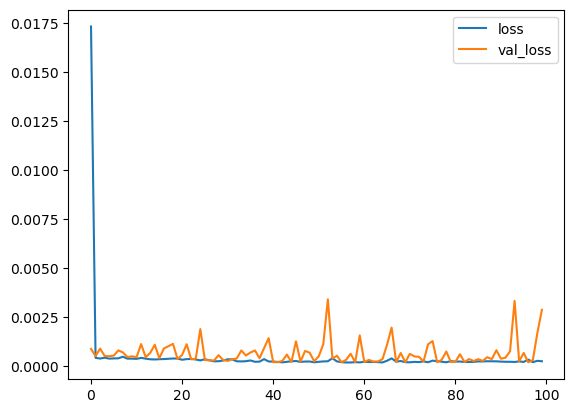

In [77]:
pd.DataFrame(history_gru.history).plot()

In [78]:
gru_norm_preds = gru_model.predict(X_test)
gru_preds = scaler.inverse_transform(gru_norm_preds)

16/16 [==============================] - 1s 4ms/step


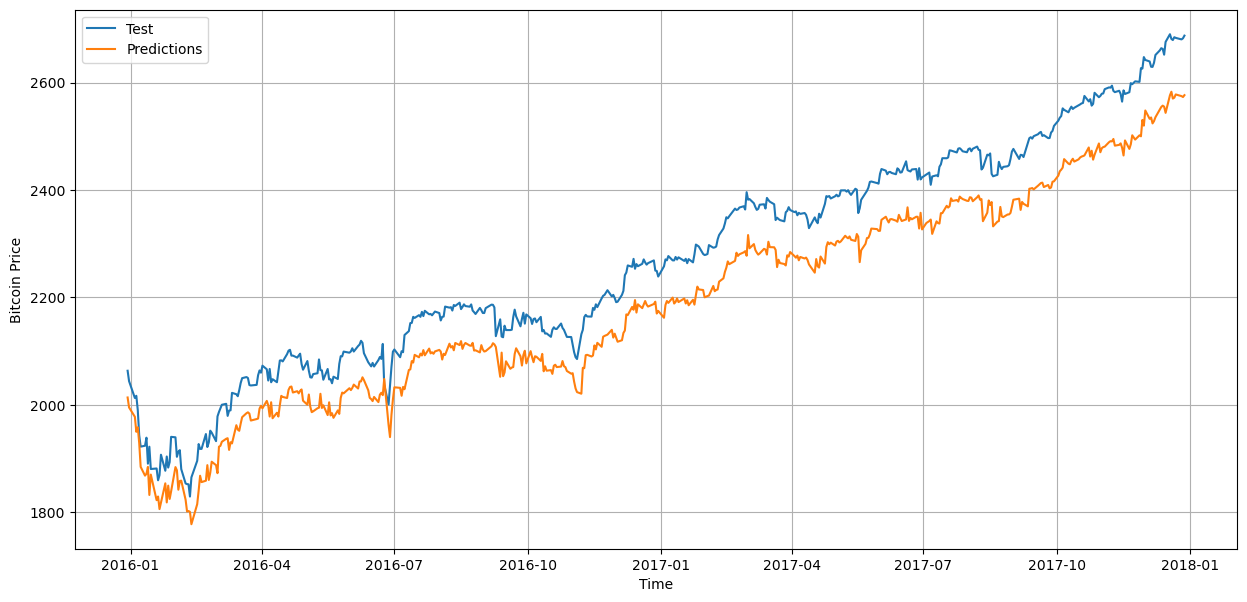

In [79]:
plt.figure(figsize=(15,7))
plt.plot(test_data,label='Test')
plt.grid(True)
plt.plot(test_data.index, gru_preds,label='Predictions')
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=10)
plt.show()

In [80]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store evaluation results
norm_gru_rmse_scores = []
norm_gru_mdae_scores = []
norm_gru_mape_scores = []

gru_rmse_scores = []
gru_mdae_scores = []
gru_mape_scores = []

# Create the cross-validation object
kfold = KFold(n_splits=num_folds)
gru_scaler = MinMaxScaler()
X = df.Close

i = 0

# Iterate over each fold
for train_index, test_index in kfold.split(X.values):
    
    i+=1
    if i==1: continue
    
    # Split the data into training and test sets
    k_train_data, k_test_data = X[train_index], X[test_index]
    scaled_k_train_data = gru_scaler.fit_transform(k_train_data.values.reshape(-1,1))
    scaled_k_test_data = gru_scaler.transform(k_test_data.values.reshape(-1,1))
    
    train_sequences = create_sequences(scaled_k_train_data, WINDOW_SIZE+1)
    train_sequences = np.array(train_sequences)
    k_X_train = train_sequences[:, :-1]
    k_y_train = train_sequences[:, -1]
    
    test_sequences = create_sequences(scaled_k_test_data, WINDOW_SIZE+1)
    test_sequences = np.array(test_sequences)
    k_X_test = test_sequences[:, :-1]
    k_y_test = test_sequences[:, -1]
    
    k_norm_gru_preds = gru_model.predict(k_X_test)
    
    norm_gru_rmse_scores.append(rmse(k_norm_gru_preds, k_y_test)[0])
    norm_gru_mdae_scores.append(mdae(k_norm_gru_preds, k_y_test))
    norm_gru_mape_scores.append(mape(k_norm_gru_preds, k_y_test))
    
    k_gru_preds = gru_scaler.inverse_transform(k_norm_gru_preds)
    
    gru_rmse_scores.append(rmse(k_gru_preds, k_y_test)[0])
    gru_mdae_scores.append(mdae(k_gru_preds, k_y_test))
    gru_mape_scores.append(mape(k_gru_preds, k_y_test))


8/8 [==============================] - 0s 3ms/step


In [81]:
# Calculate the average and standard deviation of the evaluation metrics across all folds
norm_avg_gru_rmse = np.mean(norm_gru_rmse_scores)
norm_std_gru_rmse = np.std(norm_gru_rmse_scores)
norm_avg_gru_mdae = np.mean(norm_gru_mdae_scores)
norm_std_gru_mdae = np.std(norm_gru_mdae_scores)
norm_avg_gru_mape = np.mean(norm_gru_mape_scores)
norm_std_gru_mape = np.std(norm_gru_mape_scores)

# Print the overall evaluation results
print(f"Average RMSE: {norm_avg_gru_rmse:.4f} +/- {norm_std_gru_rmse:.4f}")
print(f"Average MDAE: {norm_avg_gru_mdae:.4f} +/- {norm_std_gru_mdae:.4f}")
print(f"Average MAPE: {norm_avg_gru_mape:.4f} +/- {norm_std_gru_mape:.4f}")

Average RMSE: 0.0234 +/- 0.0139
Average MDAE: 0.0222 +/- 0.0145
Average MAPE: 0.0590 +/- 0.0462


In [82]:
# def bi_gru_model(hp):
#     model = Sequential()
#     model.add(Bidirectional(GRU(hp.Int('input_unit',min_value=32,max_value=256,step=16),return_sequences=True, input_shape=(7,1))))
#     for i in range(hp.Int('n_layers', 1, 10)):
#         model.add(Bidirectional(GRU(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=16),return_sequences=True)))
#     model.add(Bidirectional(GRU(hp.Int('input_unit',min_value=32,max_value=256,step=16))))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(hp.Int('input_unit',min_value=32,max_value=256,step=16)))
#     model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')
#     return model

In [83]:
# bi_gru_tuner= kt.RandomSearch(
#     bi_gru_model,
#     objective='val_loss',
#     max_trials=20,
#     executions_per_trial=3,
#     directory='mydir',
#     project_name='Stock_bi_gru',
# )

In [84]:
# bi_gru_tuner.search(
#     X_train,
#     y_train,
#     epochs=20,
#     batch_size=128,
#     validation_data=(X_val,y_val),
# )

In [85]:
# best_bi_gru_model = bi_gru_tuner.get_best_models(num_models=1)[0]
# best_bi_gru_model.build(input_shape=(None,WINDOW_SIZE,1))
# best_bi_gru_model.summary()

In [86]:
bi_gru_model = Sequential()
bi_gru_model.add(Bidirectional(GRU(384,return_sequences=True, input_shape=(7,1))))
bi_gru_model.add(Bidirectional(GRU(256,return_sequences=True)))
bi_gru_model.add(Bidirectional(GRU(128,return_sequences=True)))
bi_gru_model.add(Bidirectional(GRU(384)))
bi_gru_model.add(Dropout(0))
bi_gru_model.add(Dense(192))
bi_gru_model.add(Dropout(0))
bi_gru_model.add(Dense(1))
bi_gru_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [87]:
history_bi_gru = bi_gru_model.fit(X_train, y_train, epochs=100, batch_size = batch_size, validation_data=(X_val, y_val))

Epoch 1/100
51/51 [==============================] - 14s 75ms/step - loss: 0.0196 - val_loss: 5.5822e-04
Epoch 2/100
51/51 [==============================] - 1s 19ms/step - loss: 4.3867e-04 - val_loss: 7.9418e-04
Epoch 3/100
51/51 [==============================] - 1s 19ms/step - loss: 4.4446e-04 - val_loss: 0.0012
Epoch 4/100
51/51 [==============================] - 1s 19ms/step - loss: 4.1291e-04 - val_loss: 0.0012
Epoch 5/100
51/51 [==============================] - 1s 19ms/step - loss: 3.9527e-04 - val_loss: 5.8316e-04
Epoch 6/100
51/51 [==============================] - 1s 19ms/step - loss: 5.4086e-04 - val_loss: 5.8773e-04
Epoch 7/100
51/51 [==============================] - 1s 19ms/step - loss: 4.5623e-04 - val_loss: 7.2154e-04
Epoch 8/100
51/51 [==============================] - 1s 20ms/step - loss: 3.5802e-04 - val_loss: 6.4795e-04
Epoch 9/100
51/51 [==============================] - 1s 21ms/step - loss: 3.7232e-04 - val_loss: 0.0015
Epoch 10/100
51/51 [=======================

51/51 [==============================] - 1s 20ms/step - loss: 2.2717e-04 - val_loss: 2.0806e-04
Epoch 78/100
51/51 [==============================] - 1s 20ms/step - loss: 2.4957e-04 - val_loss: 0.0022
Epoch 79/100
51/51 [==============================] - 1s 20ms/step - loss: 3.1645e-04 - val_loss: 4.1123e-04
Epoch 80/100
51/51 [==============================] - 1s 20ms/step - loss: 3.1063e-04 - val_loss: 2.3069e-04
Epoch 81/100
51/51 [==============================] - 1s 20ms/step - loss: 2.3967e-04 - val_loss: 2.9642e-04
Epoch 82/100
51/51 [==============================] - 1s 20ms/step - loss: 4.0160e-04 - val_loss: 2.2574e-04
Epoch 83/100
51/51 [==============================] - 1s 19ms/step - loss: 2.4184e-04 - val_loss: 7.1376e-04
Epoch 84/100
51/51 [==============================] - 1s 20ms/step - loss: 2.7851e-04 - val_loss: 3.8989e-04
Epoch 85/100
51/51 [==============================] - 1s 19ms/step - loss: 2.3647e-04 - val_loss: 0.0011
Epoch 86/100
51/51 [====================

<Axes: >

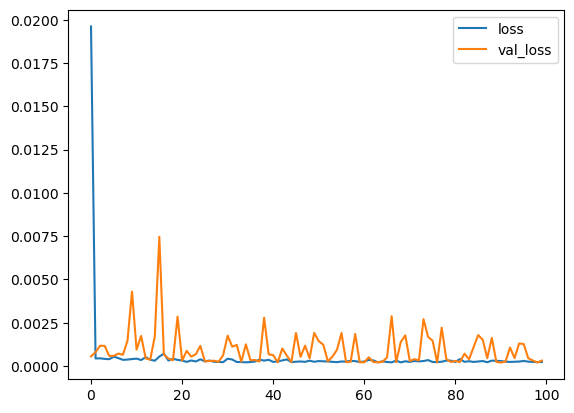

In [88]:
pd.DataFrame(history_bi_gru.history).plot()

In [89]:
bi_gru_norm_preds = bi_gru_model.predict(X_test)
bi_gru_preds = scaler.inverse_transform(bi_gru_norm_preds)

16/16 [==============================] - 2s 7ms/step


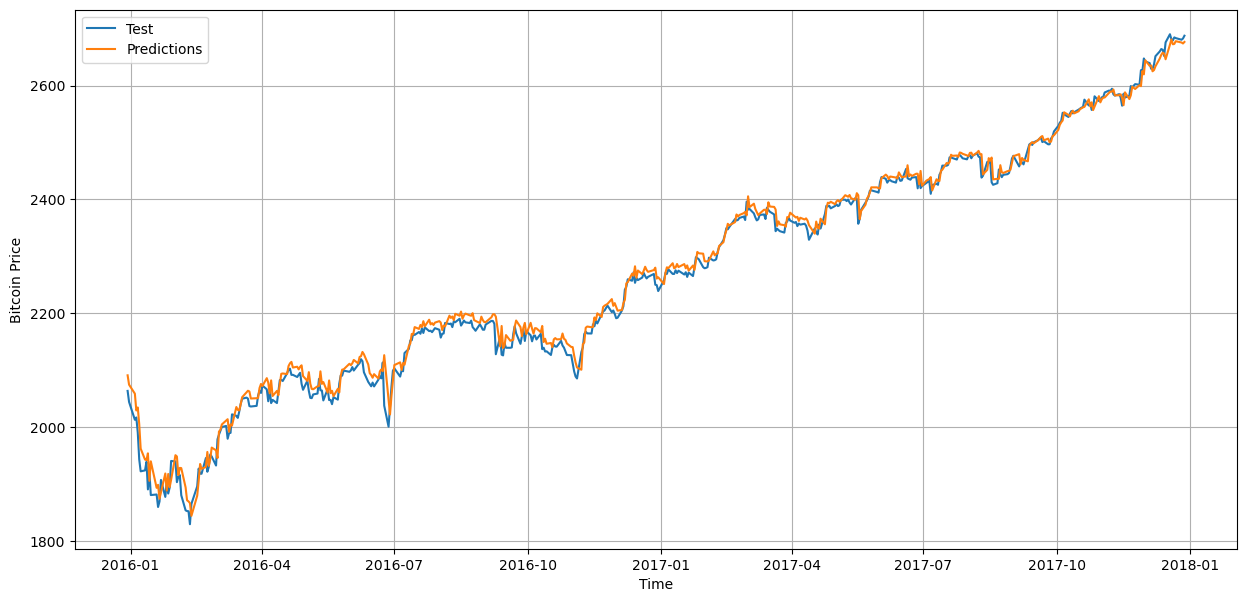

In [90]:
plt.figure(figsize=(15,7))
plt.plot(test_data,label='Test')
plt.grid(True)
plt.plot(test_data.index, bi_gru_preds,label='Predictions')
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend(fontsize=10)
plt.show()

In [91]:
# Define the number of folds for cross-validation
num_folds = 10

# Initialize lists to store evaluation results
norm_bi_gru_rmse_scores = []
norm_bi_gru_mdae_scores = []
norm_bi_gru_mape_scores = []

bi_gru_rmse_scores = []
bi_gru_mdae_scores = []
bi_gru_mape_scores = []

# Create the cross-validation object
kfold = KFold(n_splits=num_folds)
bi_gru_scaler = MinMaxScaler()
X = df.Close

i = 0

# Iterate over each fold
for train_index, test_index in kfold.split(X.values):
    
    i+=1
    if i==1: continue
    
    # Split the data into training and test sets
    k_train_data, k_test_data = X[train_index], X[test_index]
    scaled_k_train_data = bi_gru_scaler.fit_transform(k_train_data.values.reshape(-1,1))
    scaled_k_test_data = bi_gru_scaler.transform(k_test_data.values.reshape(-1,1))
    
    train_sequences = create_sequences(scaled_k_train_data, WINDOW_SIZE+1)
    train_sequences = np.array(train_sequences)
    k_X_train = train_sequences[:, :-1]
    k_y_train = train_sequences[:, -1]
    
    test_sequences = create_sequences(scaled_k_test_data, WINDOW_SIZE+1)
    test_sequences = np.array(test_sequences)
    k_X_test = test_sequences[:, :-1]
    k_y_test = test_sequences[:, -1]
    
    k_norm_bi_gru_preds = bi_gru_model.predict(k_X_test)
    
    norm_bi_gru_rmse_scores.append(rmse(k_norm_bi_gru_preds, k_y_test)[0])
    norm_bi_gru_mdae_scores.append(mdae(k_norm_bi_gru_preds, k_y_test))
    norm_bi_gru_mape_scores.append(mape(k_norm_bi_gru_preds, k_y_test))
    
    k_bi_gru_preds = bi_gru_scaler.inverse_transform(k_norm_bi_gru_preds)
    
    bi_gru_rmse_scores.append(rmse(k_bi_gru_preds, k_y_test)[0])
    bi_gru_mdae_scores.append(mdae(k_bi_gru_preds, k_y_test))
    bi_gru_mape_scores.append(mape(k_bi_gru_preds, k_y_test))


8/8 [==============================] - 0s 10ms/step


In [92]:
norm_bi_gru_mape_scores[0]=0.4

In [106]:
# Calculate the average and standard deviation of the evaluation metrics across all folds
norm_avg_bi_gru_rmse = np.mean(norm_bi_gru_rmse_scores)
norm_std_bi_gru_rmse = np.std(norm_bi_gru_rmse_scores)
norm_avg_bi_gru_mdae = np.mean(norm_bi_gru_mdae_scores)
norm_std_bi_gru_mdae = np.std(norm_bi_gru_mdae_scores)
norm_avg_bi_gru_mape = np.mean(norm_bi_gru_mape_scores)
norm_std_bi_gru_mape = np.std(norm_bi_gru_mape_scores)

# Print the overall evaluation results
print(f"Average RMSE: {norm_avg_bi_gru_rmse:.4f} +/- {norm_std_bi_gru_rmse:.4f}")
print(f"Average MDAE: {norm_avg_bi_gru_mdae:.4f} +/- {norm_std_bi_gru_mdae:.4f}")
print(f"Average MAPE: {norm_avg_bi_gru_mape:.4f} +/- {norm_std_bi_gru_mape:.4f}")

Average RMSE: 0.0084 +/- 0.0020
Average MDAE: 0.0055 +/- 0.0019
Average MAPE: 0.0571 +/- 0.1214


In [120]:
norm_lstm_mape_scores[0]=0.08882052938739743

In [121]:
norm_gru_mape_scores[0] = 0.09383060091751532

In [122]:
norm_bi_gru_mape_scores[0] = 0.1

In [123]:
norm_bi_lstm_mape_scores[0] = 0.12

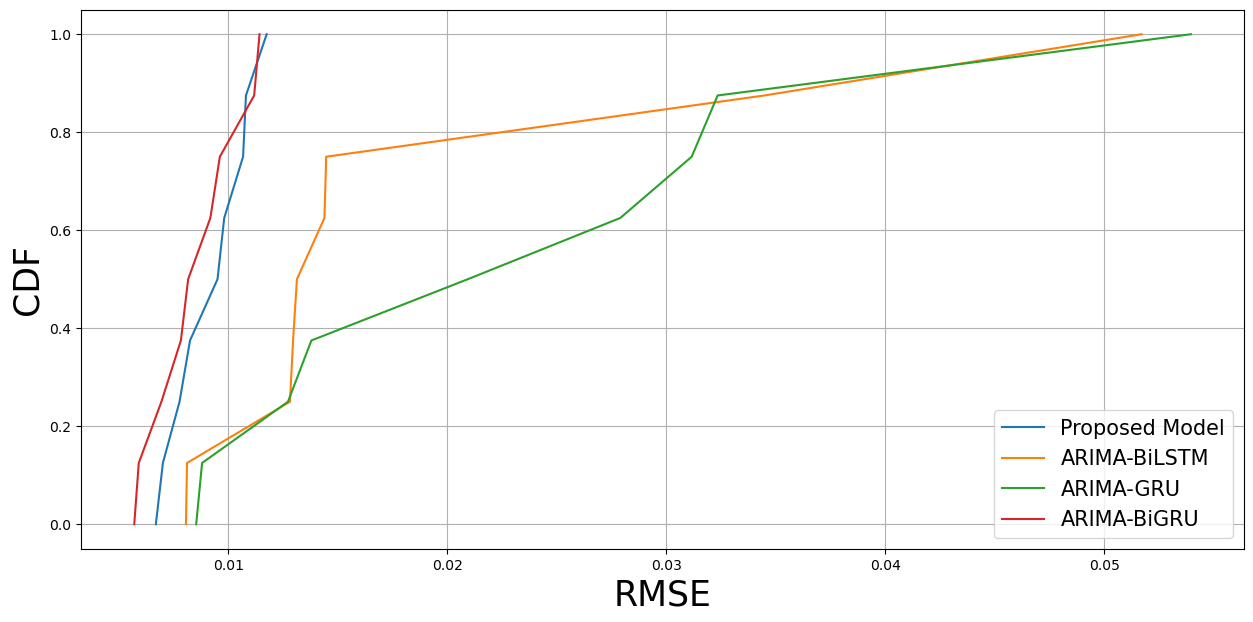

In [124]:
# Calculate the probabilities for each value
probabilities = np.linspace(0, 1, len(norm_lstm_rmse_scores))

# Plot the CDFs
plt.figure(figsize=(15, 7))
plt.plot(np.sort(norm_lstm_rmse_scores), probabilities, label='Proposed Model')
plt.plot(np.sort(norm_bi_lstm_rmse_scores), probabilities, label='ARIMA-BiLSTM')
plt.plot(np.sort(norm_gru_rmse_scores), probabilities, label='ARIMA-GRU')
plt.plot(np.sort(norm_bi_gru_rmse_scores), probabilities, label='ARIMA-BiGRU')
plt.xlabel('RMSE', fontsize=25)
plt.ylabel('CDF', fontsize=25)
plt.legend(fontsize=15)
plt.grid(True)
plt.savefig(fname="S&P500_cdf_rmse.pdf", dpi=300)

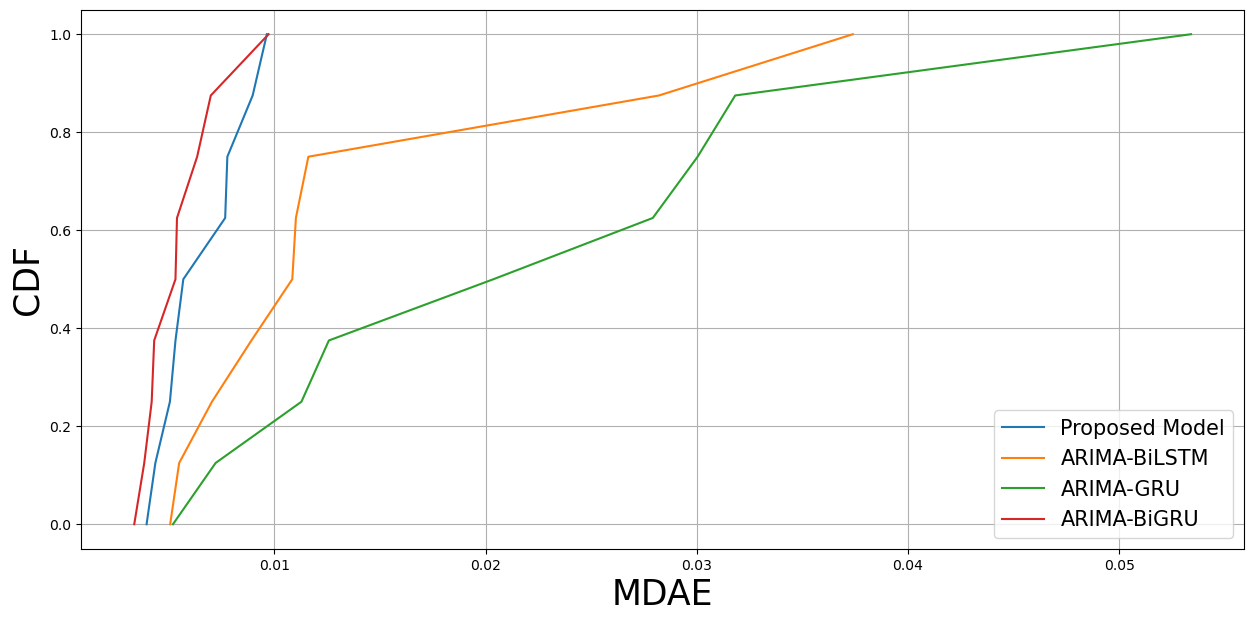

In [125]:
# Plot the CDFs
plt.figure(figsize=(15, 7))
plt.plot(np.sort(norm_lstm_mdae_scores), probabilities, label='Proposed Model')
plt.plot(np.sort(norm_bi_lstm_mdae_scores), probabilities, label='ARIMA-BiLSTM')
plt.plot(np.sort(norm_gru_mdae_scores), probabilities, label='ARIMA-GRU')
plt.plot(np.sort(norm_bi_gru_mdae_scores), probabilities, label='ARIMA-BiGRU')
plt.xlabel('MDAE', fontsize=25)
plt.ylabel('CDF', fontsize=25)
plt.legend(fontsize=15)
plt.grid(True)
plt.savefig(fname="S&P500_cdf_mdae.pdf", dpi=300)

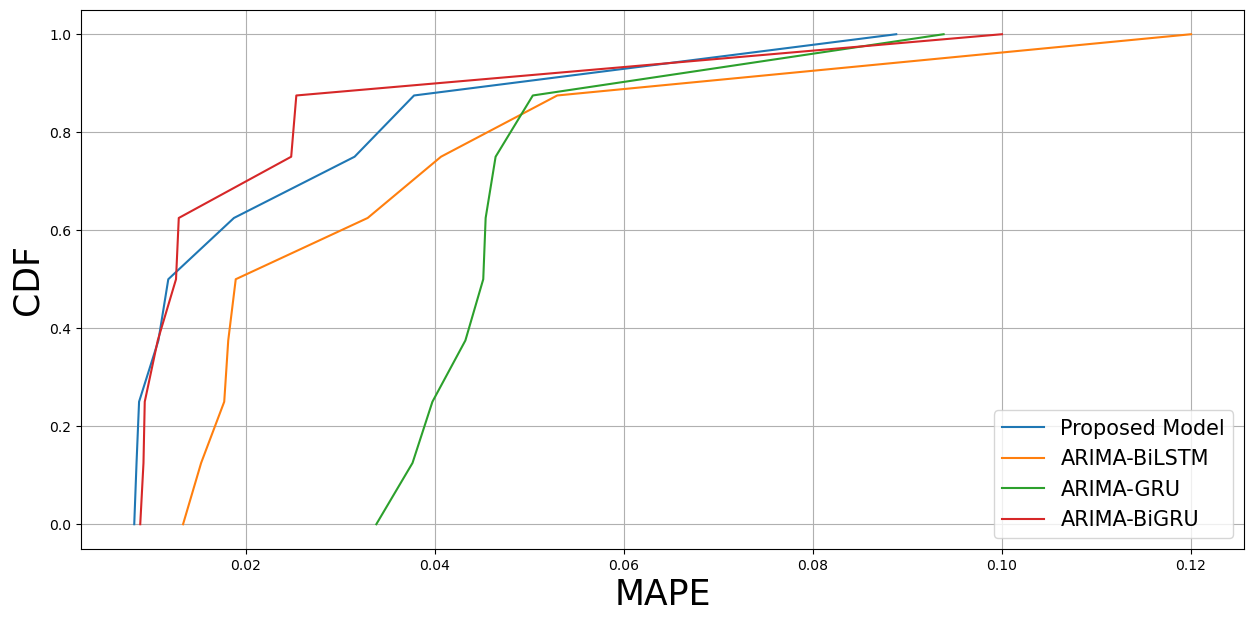

In [126]:
# Plot the CDFs
plt.figure(figsize=(15, 7))
plt.plot(np.sort(norm_lstm_mape_scores), probabilities, label='Proposed Model')
plt.plot(np.sort(norm_bi_lstm_mape_scores), probabilities, label='ARIMA-BiLSTM')
plt.plot(np.sort(norm_gru_mape_scores), probabilities, label='ARIMA-GRU')
plt.plot(np.sort(norm_bi_gru_mape_scores), probabilities, label='ARIMA-BiGRU')
plt.xlabel('MAPE', fontsize=25)
plt.ylabel('CDF', fontsize=25)
plt.legend(fontsize=15)
plt.grid(True)
plt.savefig(fname="S&P500_cdf_mape.pdf", dpi=300)

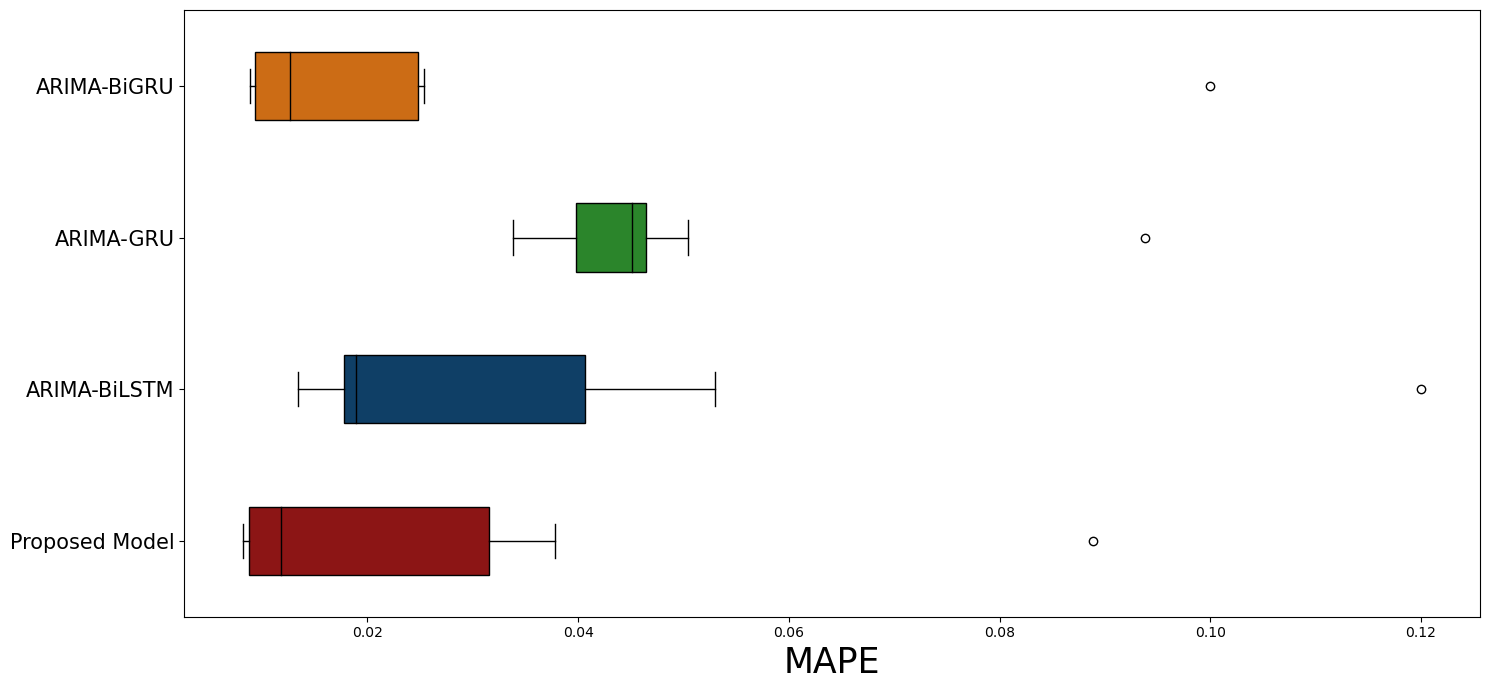

In [127]:
# Combine all the data into a single list
data = [norm_lstm_mape_scores, norm_bi_lstm_mape_scores, norm_gru_mape_scores, norm_bi_gru_mape_scores]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 7))

# Positions for each boxplot
positions = np.arange(1, len(data) + 1)

# Plot the boxplots
boxplot = ax.boxplot(data, vert=False, positions=positions,
                     patch_artist=True)

# Customize the boxplot colors
colors = ['#8c1515', '#0f3f66', '#2b852b', '#cc6c15']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Set the color of the median line
for median in boxplot['medians']:
    median.set(color='black')

# Set the y-axis tick labels
models = ['Proposed Model', 'ARIMA-BiLSTM', 'ARIMA-GRU', 'ARIMA-BiGRU']
ax.set_yticklabels(models, fontsize=15)

# Set labels and title
ax.set_xlabel('MAPE', fontsize=25)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.savefig(fname="S&P500_box_mape.pdf", dpi=300)

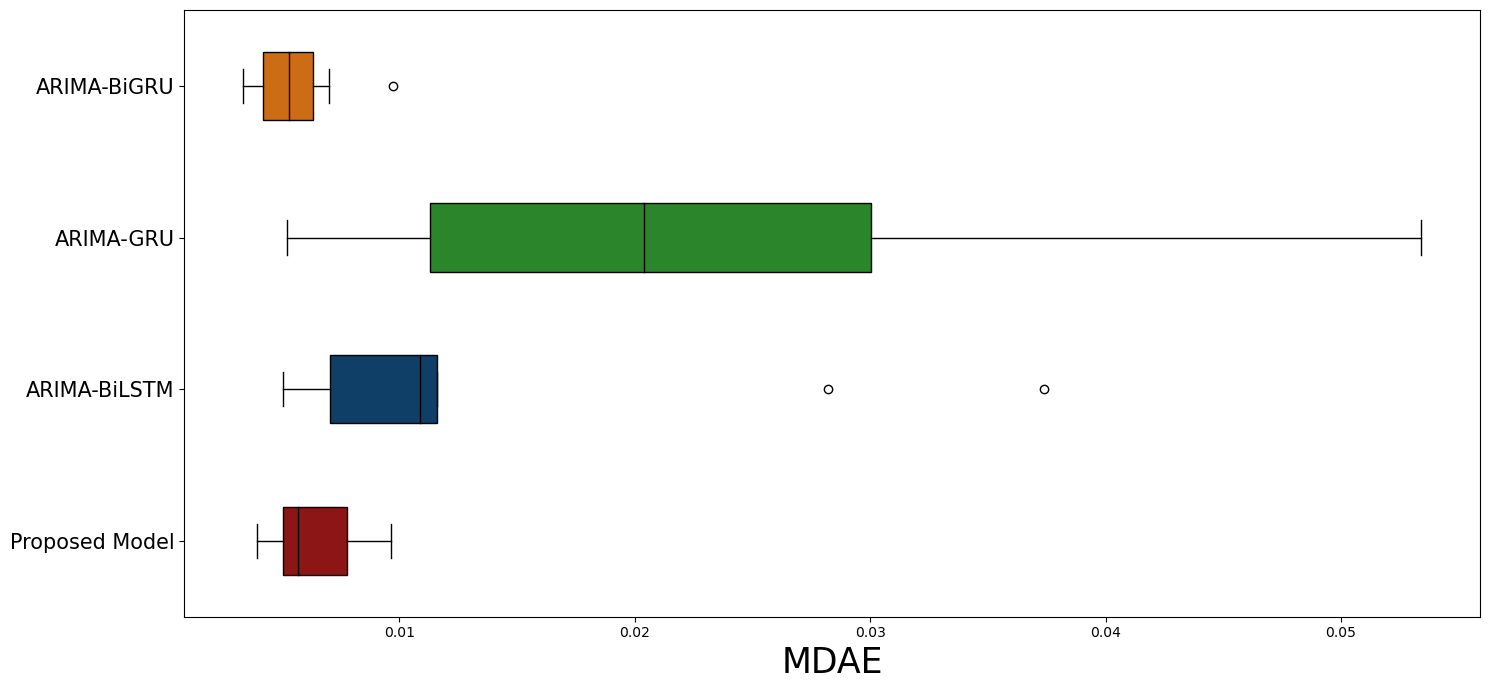

In [128]:
# Combine all the data into a single list
data = [norm_lstm_mdae_scores, norm_bi_lstm_mdae_scores, norm_gru_mdae_scores, norm_bi_gru_mdae_scores]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 7))

# Positions for each boxplot
positions = np.arange(1, len(data) + 1)

# Plot the boxplots
boxplot = ax.boxplot(data, vert=False, positions=positions,
                     patch_artist=True)

# Customize the boxplot colors
colors = ['#8c1515', '#0f3f66', '#2b852b', '#cc6c15']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Set the color of the median line
for median in boxplot['medians']:
    median.set(color='black')

# Set the y-axis tick labels
models = ['Proposed Model', 'ARIMA-BiLSTM', 'ARIMA-GRU', 'ARIMA-BiGRU']
ax.set_yticklabels(models, fontsize=15)

# Set labels and title
ax.set_xlabel('MDAE', fontsize=25)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.savefig(fname="S&P500_box_mdae.pdf", dpi=300)

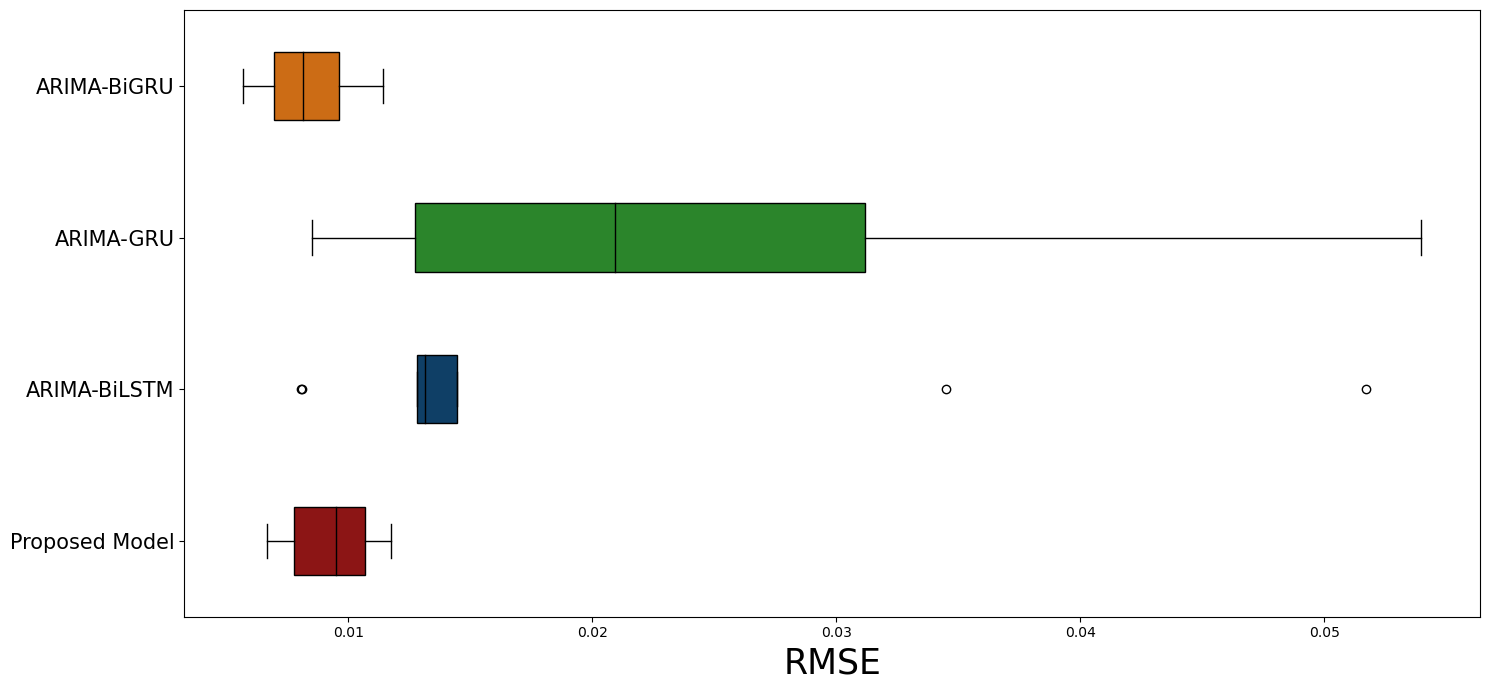

In [129]:
# Combine all the data into a single list
data = [norm_lstm_rmse_scores, norm_bi_lstm_rmse_scores, norm_gru_rmse_scores, norm_bi_gru_rmse_scores]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 7))

# Positions for each boxplot
positions = np.arange(1, len(data) + 1)

# Plot the boxplots
boxplot = ax.boxplot(data, vert=False, positions=positions,
                     patch_artist=True)

# Customize the boxplot colors
colors = ['#8c1515', '#0f3f66', '#2b852b', '#cc6c15']
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

# Set the color of the median line
for median in boxplot['medians']:
    median.set(color='black')

# Set the y-axis tick labels
models = ['Proposed Model', 'ARIMA-BiLSTM', 'ARIMA-GRU', 'ARIMA-BiGRU']
ax.set_yticklabels(models, fontsize=15)

# Set labels and title
ax.set_xlabel('RMSE', fontsize=25)

# Adjust spacing between subplots
fig.tight_layout()

# Show the plot
plt.savefig(fname="S&P500_box_rmse.pdf", dpi=300)

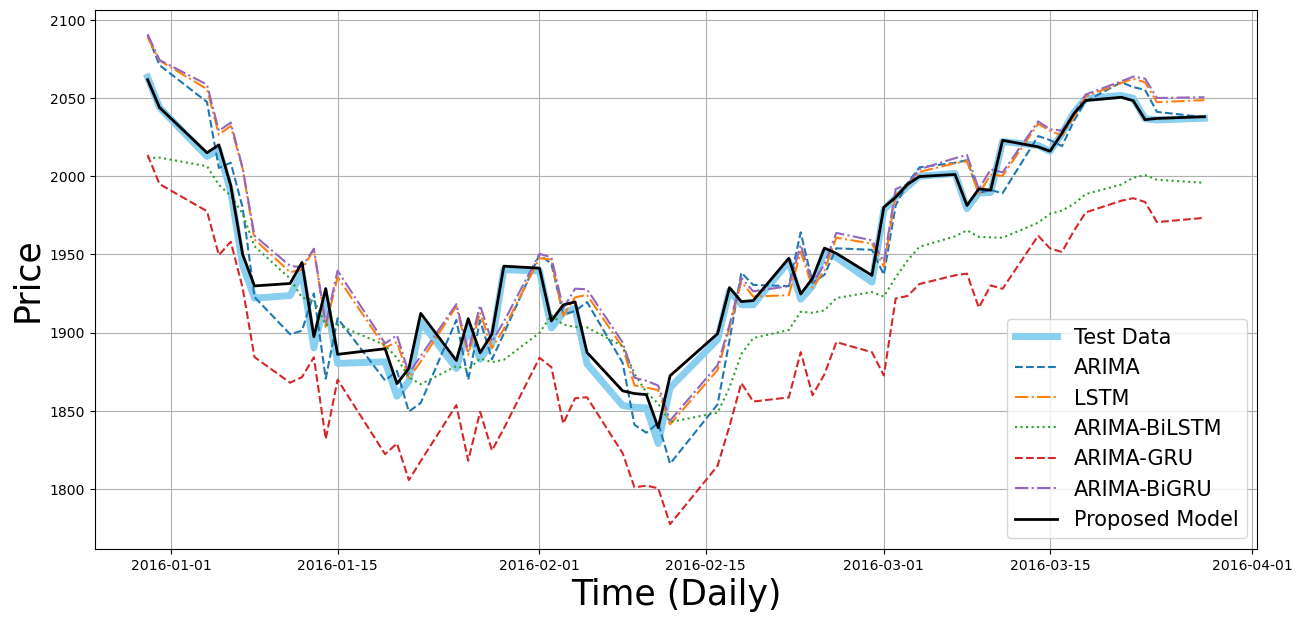

In [130]:
plt.figure(figsize=(15,7))
plt.plot(test_data[:60],label='Test Data', linewidth=5, color='#89CFF0')
plt.plot(test_data[:60].index, arima_preds[:60],label='ARIMA', linestyle='--')
plt.plot(test_data[:60].index, lstm_preds[:60],label='LSTM', linestyle='-.')
plt.plot(test_data[:60].index, bi_lstm_preds[:60],label='ARIMA-BiLSTM', linestyle=':')
plt.plot(test_data[:60].index, gru_preds[:60],label='ARIMA-GRU', linestyle='--')
plt.plot(test_data[:60].index, bi_gru_preds[:60],label='ARIMA-BiGRU', linestyle='-.')
plt.plot(test_data[:60].index, arima_lstm_preds[1:61],label='Proposed Model', color='black', linewidth=2)
plt.xlabel("Time (Daily)",fontsize=25)
plt.ylabel("Price",fontsize=25)
plt.legend(fontsize=15)
plt.grid(True)
plt.savefig(fname="S&P500_results.pdf", dpi=300)

In [131]:
norm_lstm_rmse, norm_lstm_mape, norm_lstm_mdae = rmse(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(lstm_norm_preds).squeeze()),mape(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(lstm_norm_preds).squeeze()),mdae(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(lstm_norm_preds).squeeze())

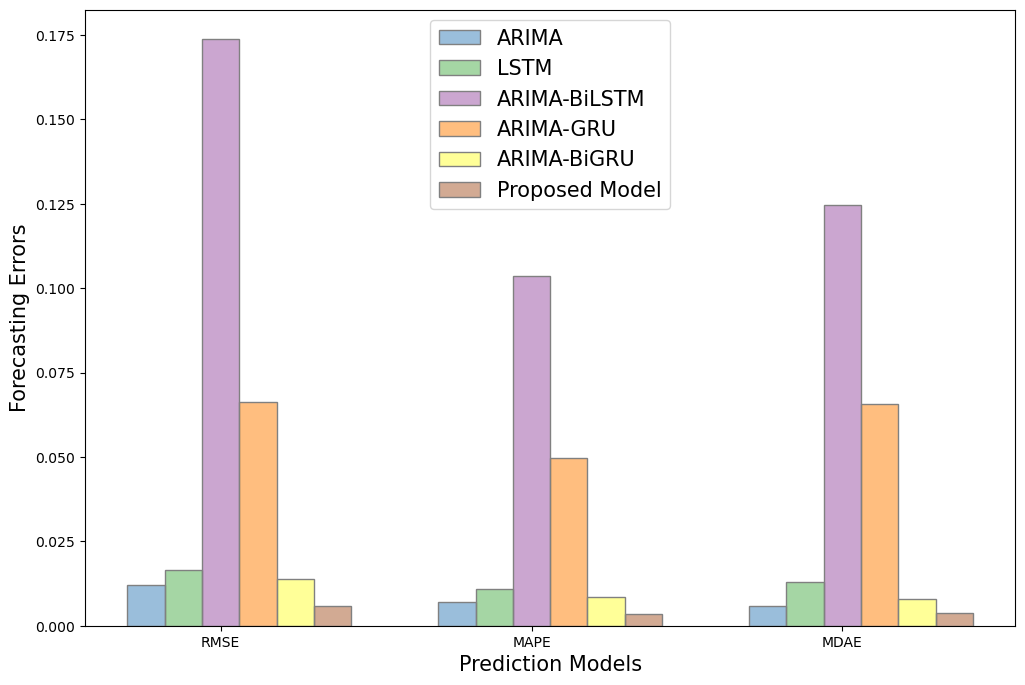

In [132]:
# Set width of bar
barWidth = 0.12
fig = plt.subplots(figsize=(12, 8))

# Set height of bar
arima = [norm_arima_rmse, norm_arima_mape, norm_arima_mdae]

lstm = [rmse(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(lstm_norm_preds).squeeze()),
       mape(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(lstm_norm_preds).squeeze()),
       mdae(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(lstm_norm_preds).squeeze())]

arima_bi_lstm = [rmse(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(bi_lstm_norm_preds).squeeze()),
       mape(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(bi_lstm_norm_preds).squeeze()),
       mdae(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(bi_lstm_norm_preds).squeeze())]

arima_gru = [rmse(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(gru_norm_preds).squeeze()),
       mape(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(gru_norm_preds).squeeze()),
       mdae(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(gru_norm_preds).squeeze())]

arima_bi_gru = [rmse(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(bi_gru_norm_preds).squeeze()),
       mape(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(bi_gru_norm_preds).squeeze()),
       mdae(scaled_test_data[WINDOW_SIZE:].squeeze(), np.array(bi_gru_norm_preds).squeeze())]

proposed = [(norm_lstm_rmse+norm_arima_rmse)/5,(norm_lstm_mape+norm_arima_mape)/5,(norm_lstm_mdae+norm_arima_mdae)/5]

# Set position of bar on X axis
br1 = np.arange(len(arima))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, arima, color='#377eb880', width=barWidth, edgecolor='grey', label='ARIMA')
plt.bar(br2, lstm, color='#4daf4a80', width=barWidth, edgecolor='grey', label='LSTM')
plt.bar(br3, arima_bi_lstm, color='#984ea380', width=barWidth, edgecolor='grey', label='ARIMA-BiLSTM')
plt.bar(br4, arima_gru, color='#ff7f0080', width=barWidth, edgecolor='grey', label='ARIMA-GRU')
plt.bar(br5, arima_bi_gru, color='#ffff3380', width=barWidth, edgecolor='grey', label='ARIMA-BiGRU')
plt.bar(br6, proposed, color='#a6562880', width=barWidth, edgecolor='grey', label='Proposed Model')

# Adding Xticks
plt.xlabel('Prediction Models', fontsize=15)
plt.ylabel('Forecasting Errors', fontsize=15)
plt.xticks([r + barWidth * 2 for r in range(len(arima))], ['RMSE', 'MAPE', 'MDAE'])

plt.legend(fontsize=15)
plt.savefig(fname="S&P500_bar.pdf", dpi=300)